# GRN - based on scFates milestones (pcw16)

In [1]:
pwd

'/home/jovyan/jm_jlab/data_CBL/indNeuro_tmp/1.GRN'

In [2]:
!cd /home/jovyan/jm_jlab/

import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

import celloracle as co
co.__version__

# visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline


save_folder = "/home/jovyan/jm_jlab/data_indNeuro/1.GRN/"
os.makedirs(save_folder, exist_ok=True)

from pathlib import Path

sc._settings.ScanpyConfig.cachedir = Path('/home/jovyan/jm_jlab/celloracle_data/cache')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
save_filtered_links = "/home/jovyan/jm_jlab/data_indNeuro/consensus_atlas_ATACregions_hg38/GRN_trevino21/milestones_pcw16/"

## **scRNA-seq processing**

In [4]:
adata = sc.read_h5ad("/home/jovyan/jm_jlab/data_indNeuro/intermediate_files/rna_counts.h5ad")

milestones = pd.read_csv("/home/jovyan/jm_jlab/data_indNeuro/scFates_output/scFates_clustering.tsv", sep='\t', index_col=0)

adata.obs = pd.concat([adata.obs, milestones], axis=1)

cellembeddings = pd.read_csv("/home/jovyan/jm_jlab/data_indNeuro/intermediate_files/cellembeddings.tsv", sep='\t')
cellembeddings.iloc[:,1] = cellembeddings.iloc[:,1]*-1 #for better geometry
adata.obsm['X_pca'] = cellembeddings.to_numpy() #sharing embeddings

adata = adata[adata.obs['Age'] == 'pcw16',:].copy()

sc.pp.filter_genes(adata, min_cells=50)
sc.pp.normalize_per_cell(adata, key_n_counts='n_counts_all')
sc.pp.highly_variable_genes(adata, n_top_genes=4000, flavor='seurat_v3') #let's retain more genes before further filtering

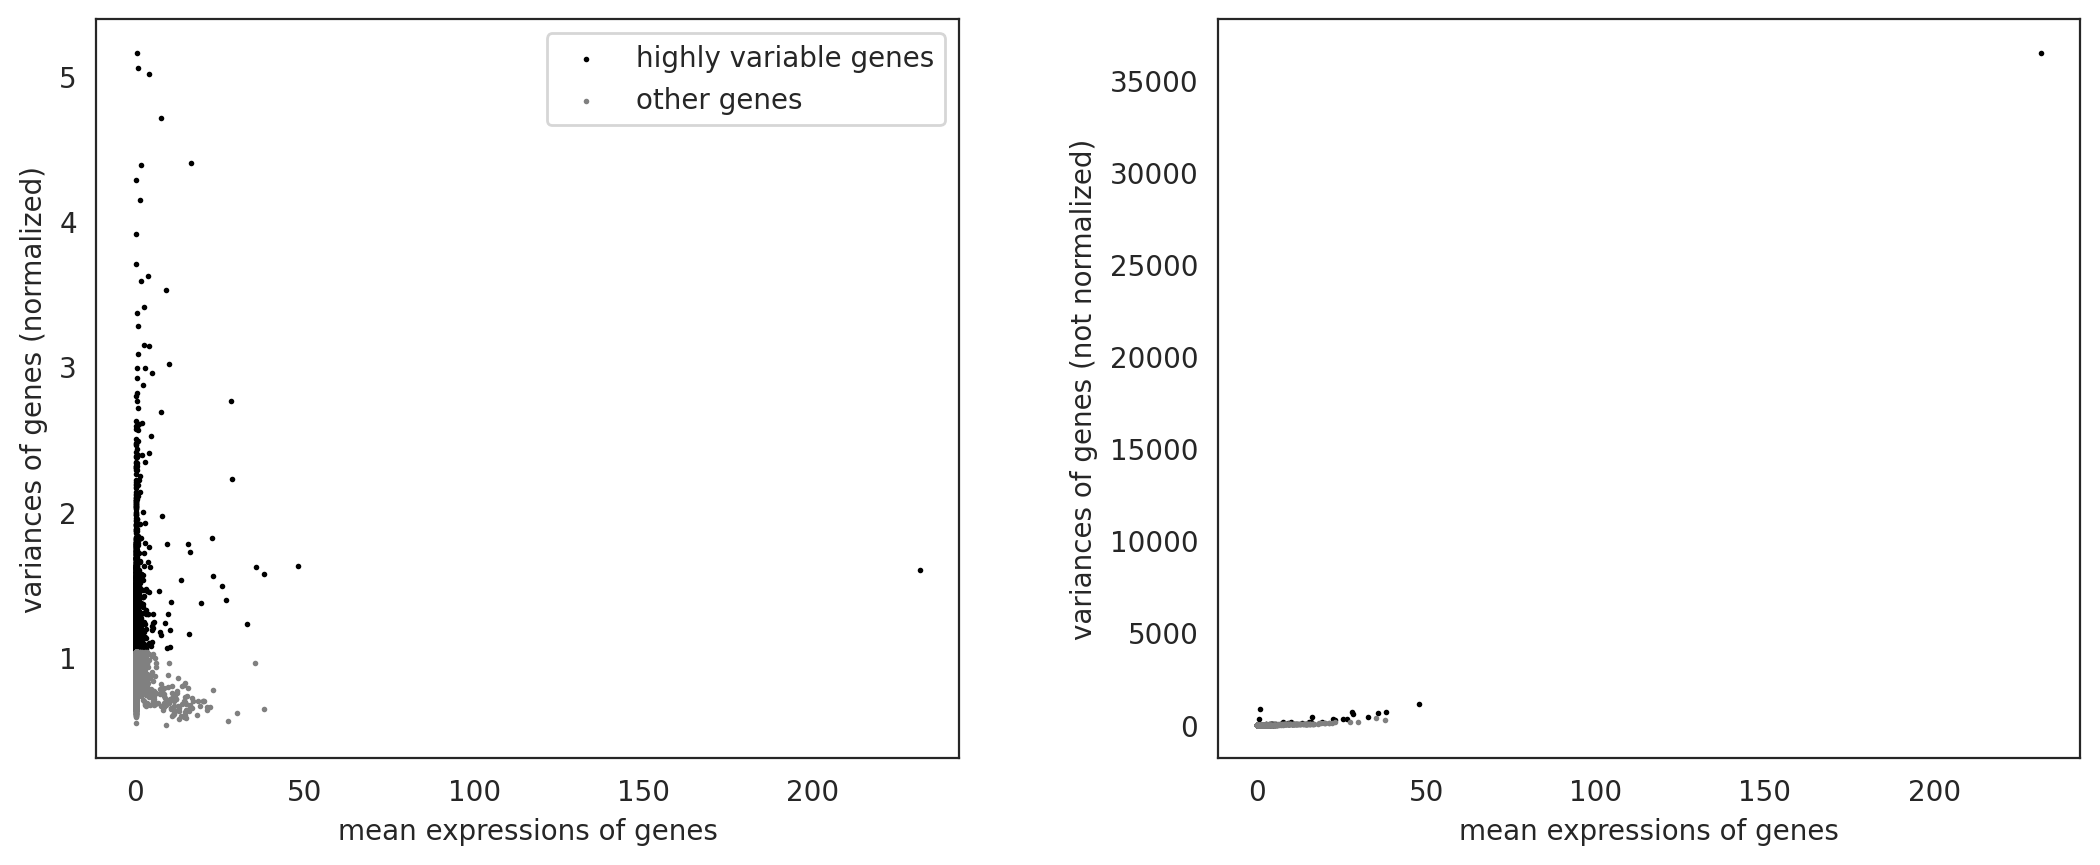

In [5]:
sc.pl.highly_variable_genes(adata)

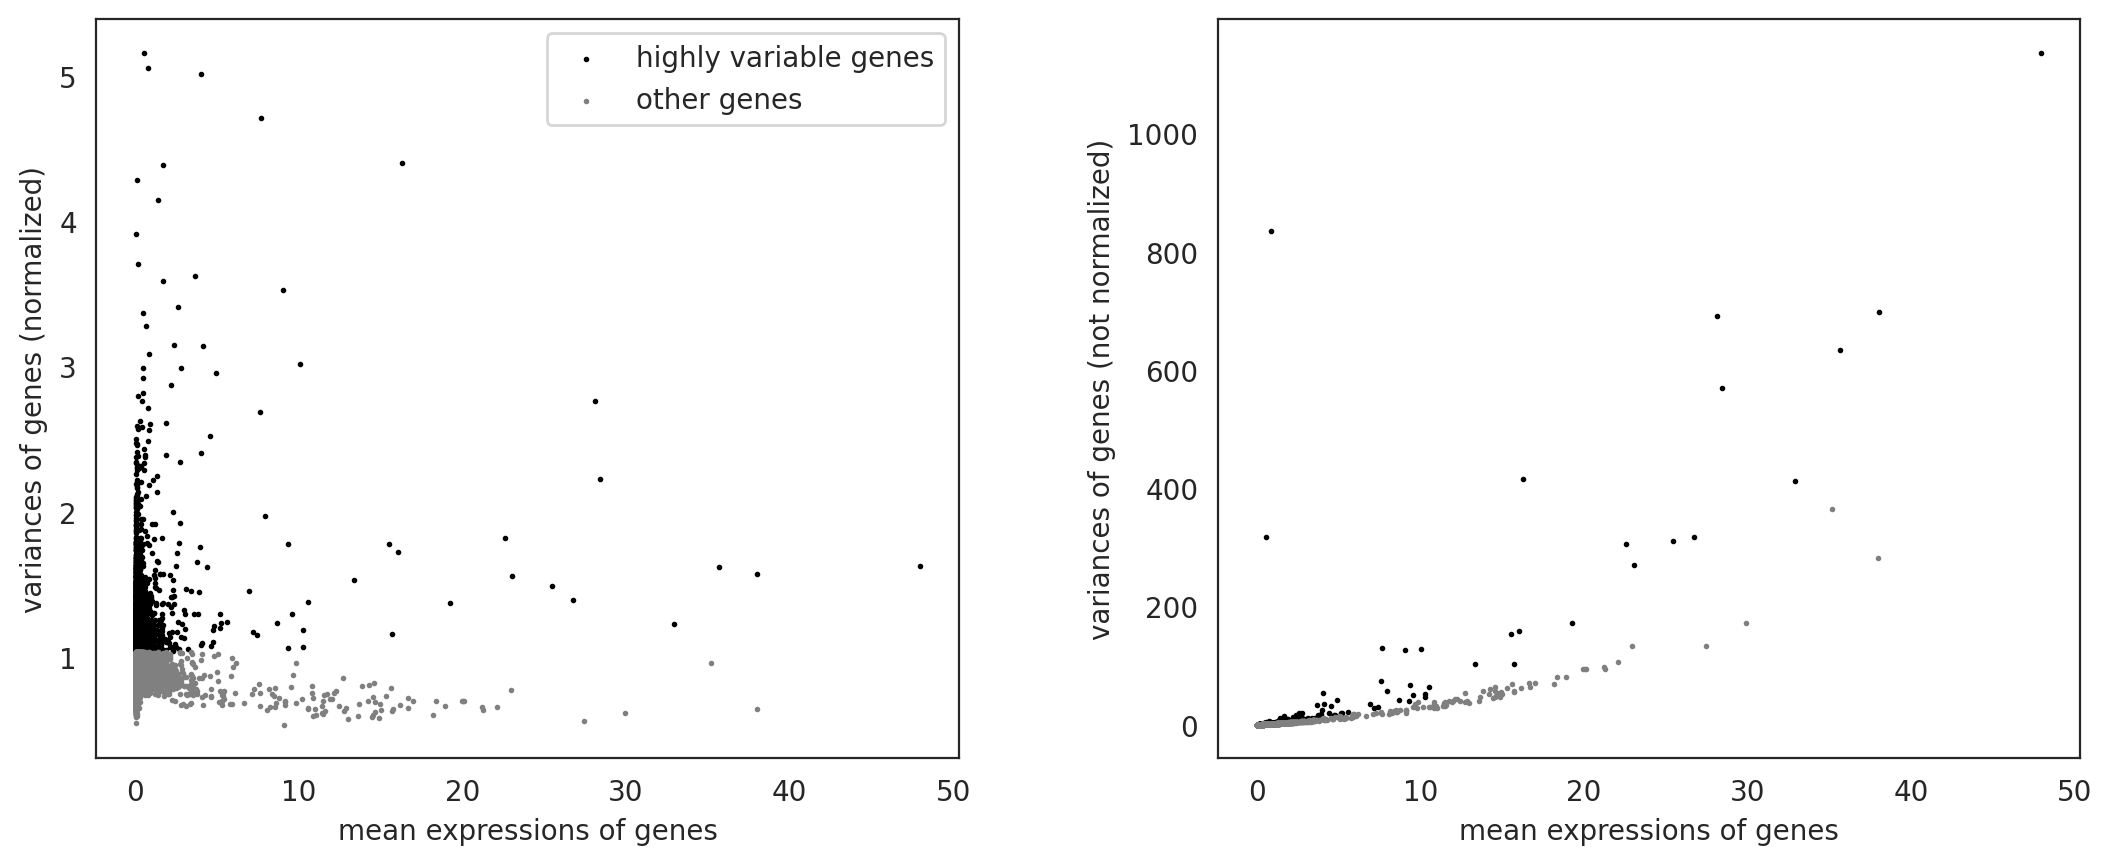

In [6]:
sc.pl.highly_variable_genes(adata[:,adata.var['means'] < 50])

In [7]:
adata=adata[:,adata.var.highly_variable]

In [8]:
#Renormalized after filtering
sc.pp.normalize_per_cell(adata, key_n_counts='n_counts_all')

In [9]:
# keep raw cont data before log transformation
adata.raw = adata.copy()
adata.layers["raw_count"] = adata.raw.X.copy()

# Log transformation
sc.pp.log1p(adata)

In [10]:
df = pd.read_parquet("/home/jovyan/jm_jlab/data_indNeuro/consensus_atlas_ATACregions_hg38/base_GRN_dataframe_HOCOMOCOv11.parquet")

df.head(2)

peak_id gene_short_name  AHR  AIRE  ALX1   AR  ARID5B  \
0  chr10_100006240_100006741           ABCC2  0.0   0.0   0.0  0.0     0.0   
1  chr10_100006240_100006741           DNMBP  0.0   0.0   0.0  0.0     0.0   

   ARNT  ARNTL  ASCL1  ...  ZNF680  ZNF708  ZNF76  ZNF768  ZNF770  ZNF8  \
0   0.0    0.0    0.0  ...     0.0     0.0    0.0     0.0     0.0   0.0   
1   0.0    0.0    0.0  ...     0.0     0.0    0.0     0.0     0.0   0.0   

   ZNF816  ZNF85  ZSCAN22  ZSCAN31  
0     0.0    0.0      0.0      0.0  
1     0.0    0.0      0.0      0.0  

[2 rows x 401 columns]

In [11]:
adata.var['TF_HOCOMOCO'] = adata.var_names.isin(df.columns[2:])

In [12]:
adata = adata[:,(adata.var['highly_variable'] == True) | (adata.var['TF_HOCOMOCO'] == True)].copy()

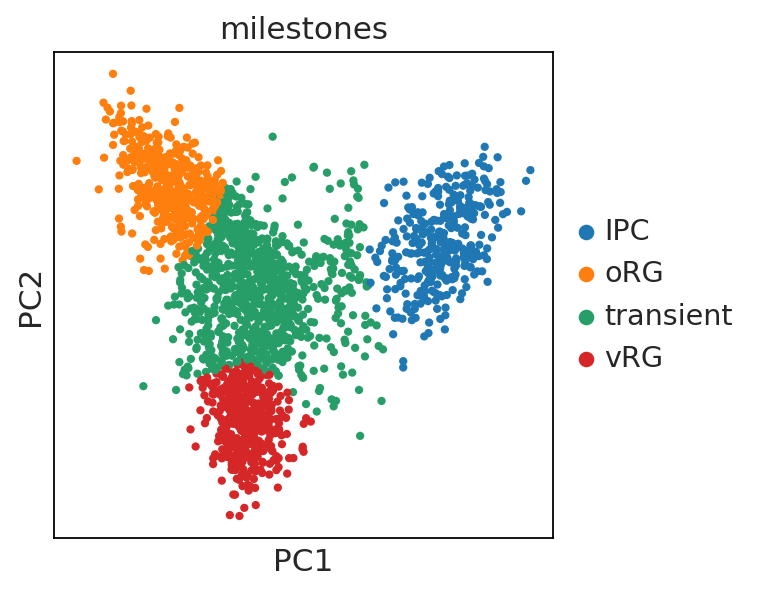

In [13]:
sc.set_figure_params(figsize=(4,4))

sc.pl.pca(adata, color=['milestones'])

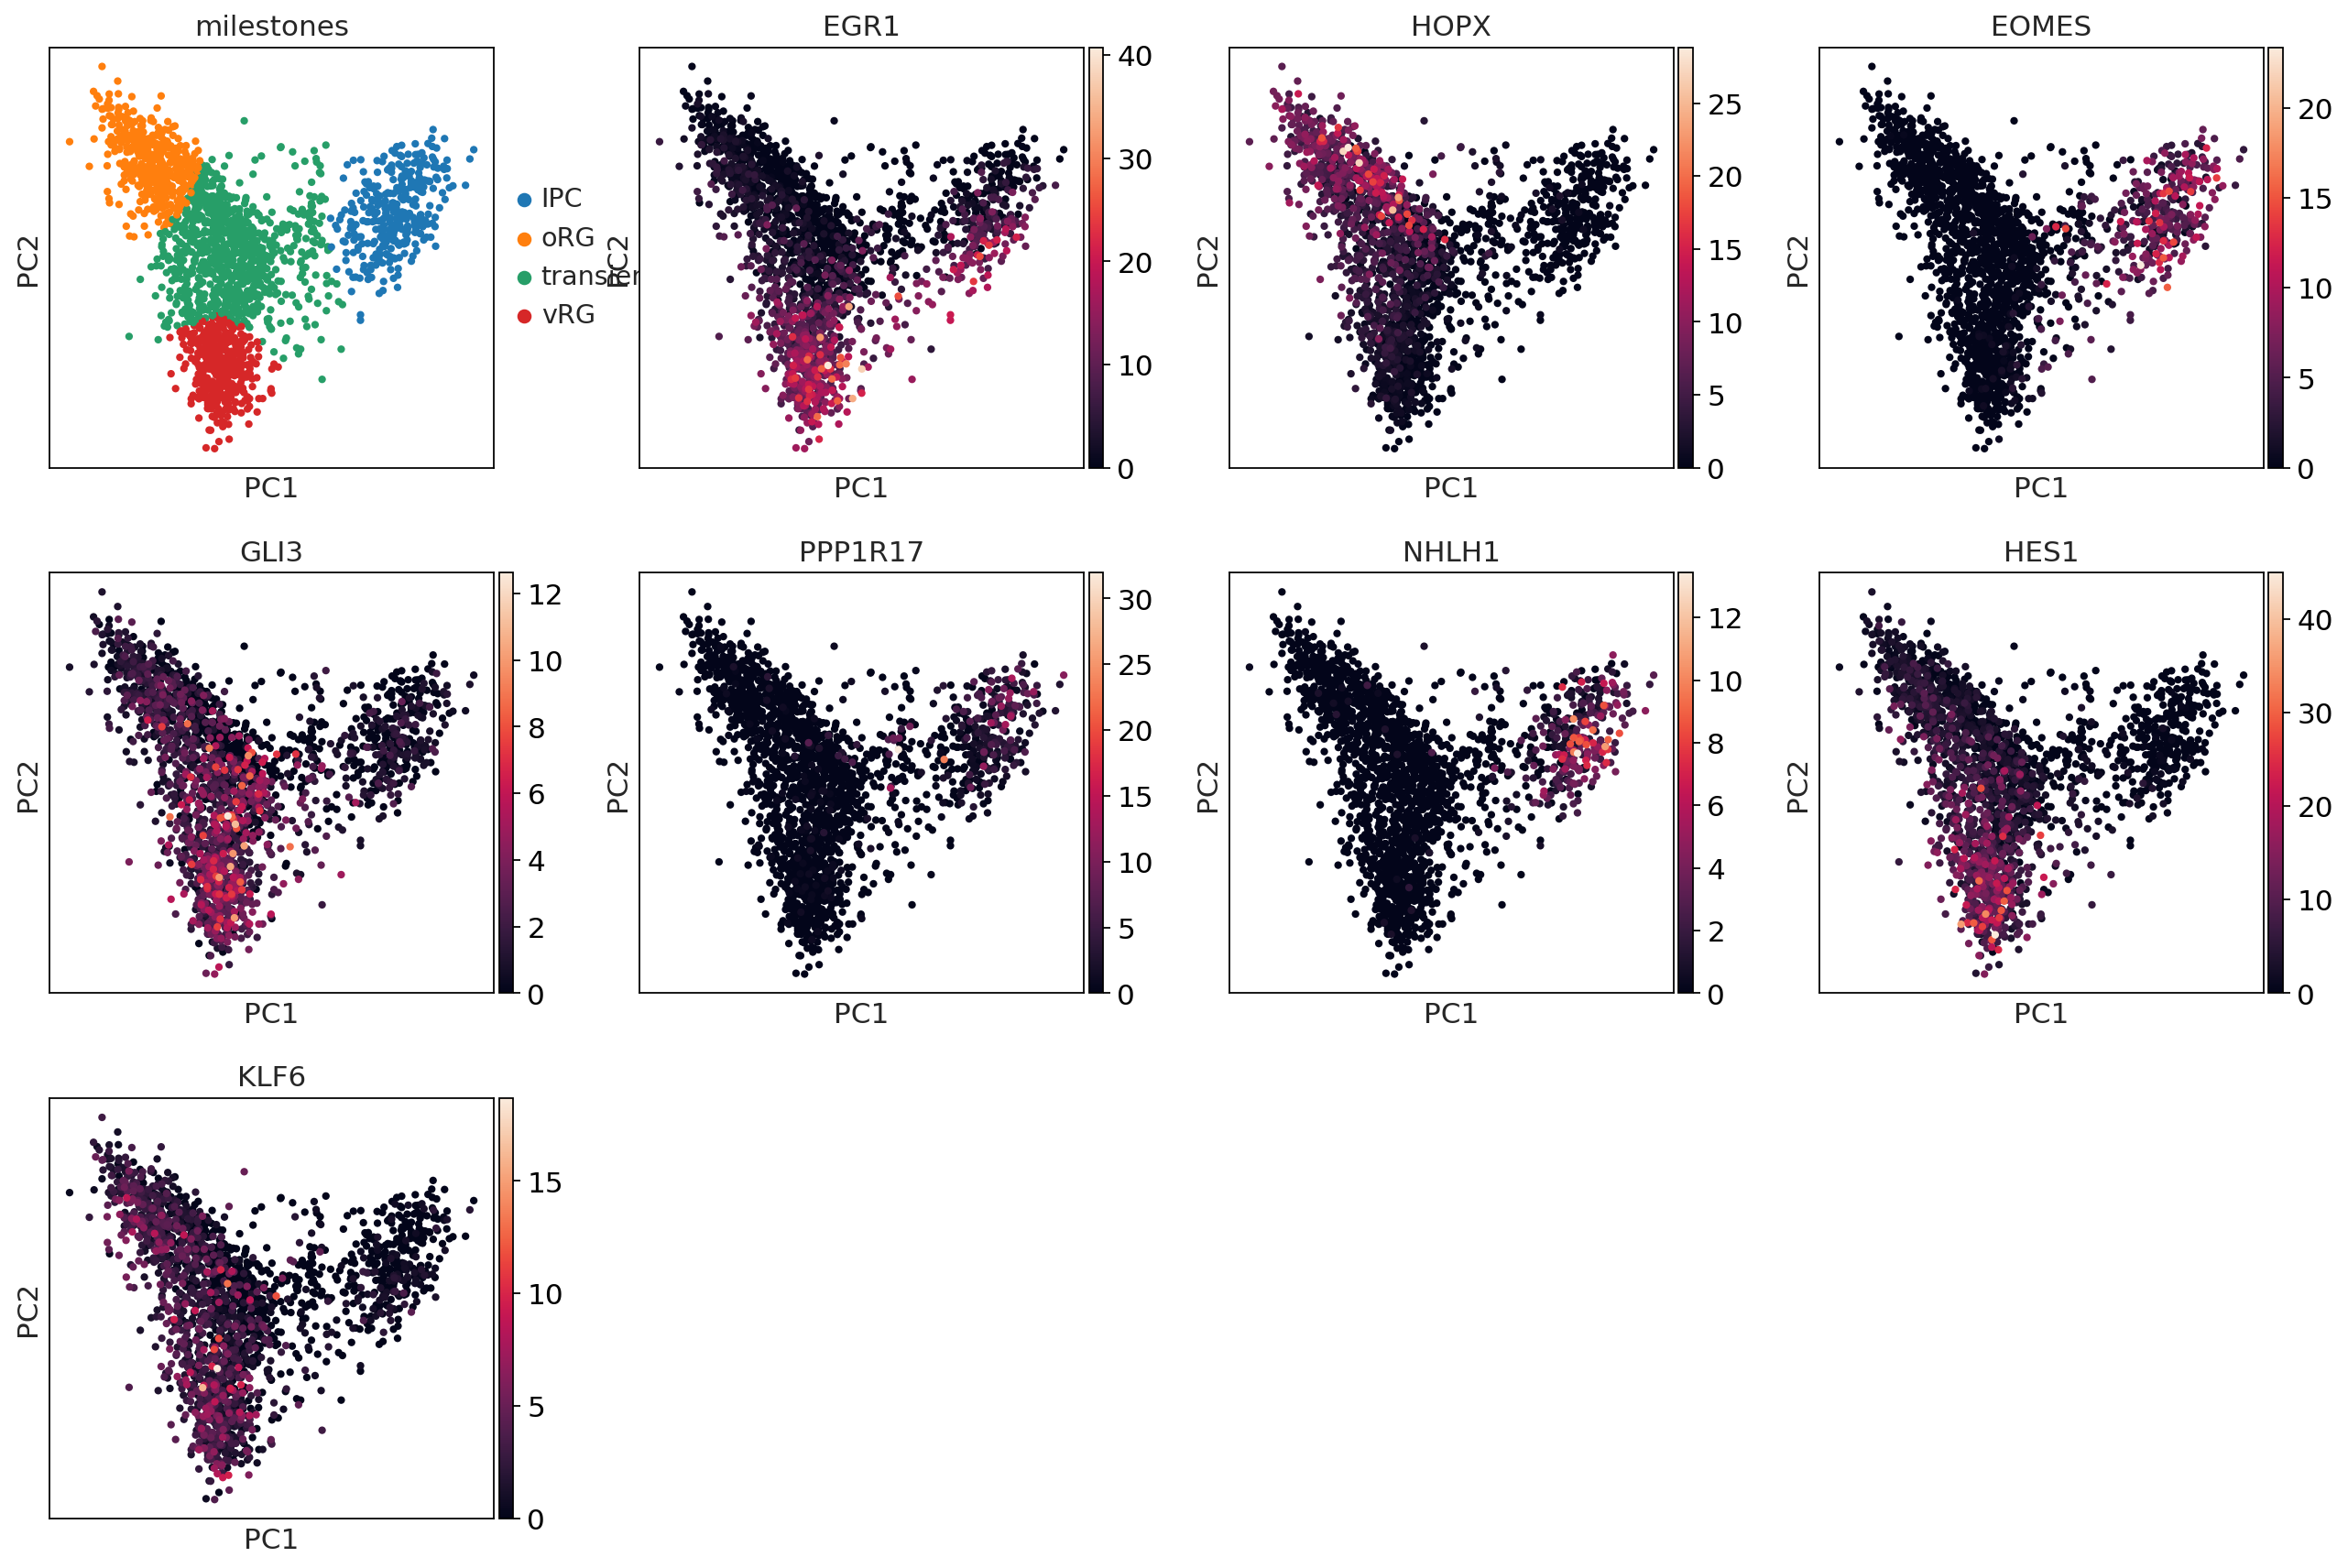

In [14]:
sc.pl.pca(adata, color=['milestones', 'EGR1', 'HOPX', 'EOMES', 'GLI3', 'PPP1R17', 'NHLH1', 'HES1', 'KLF6'])

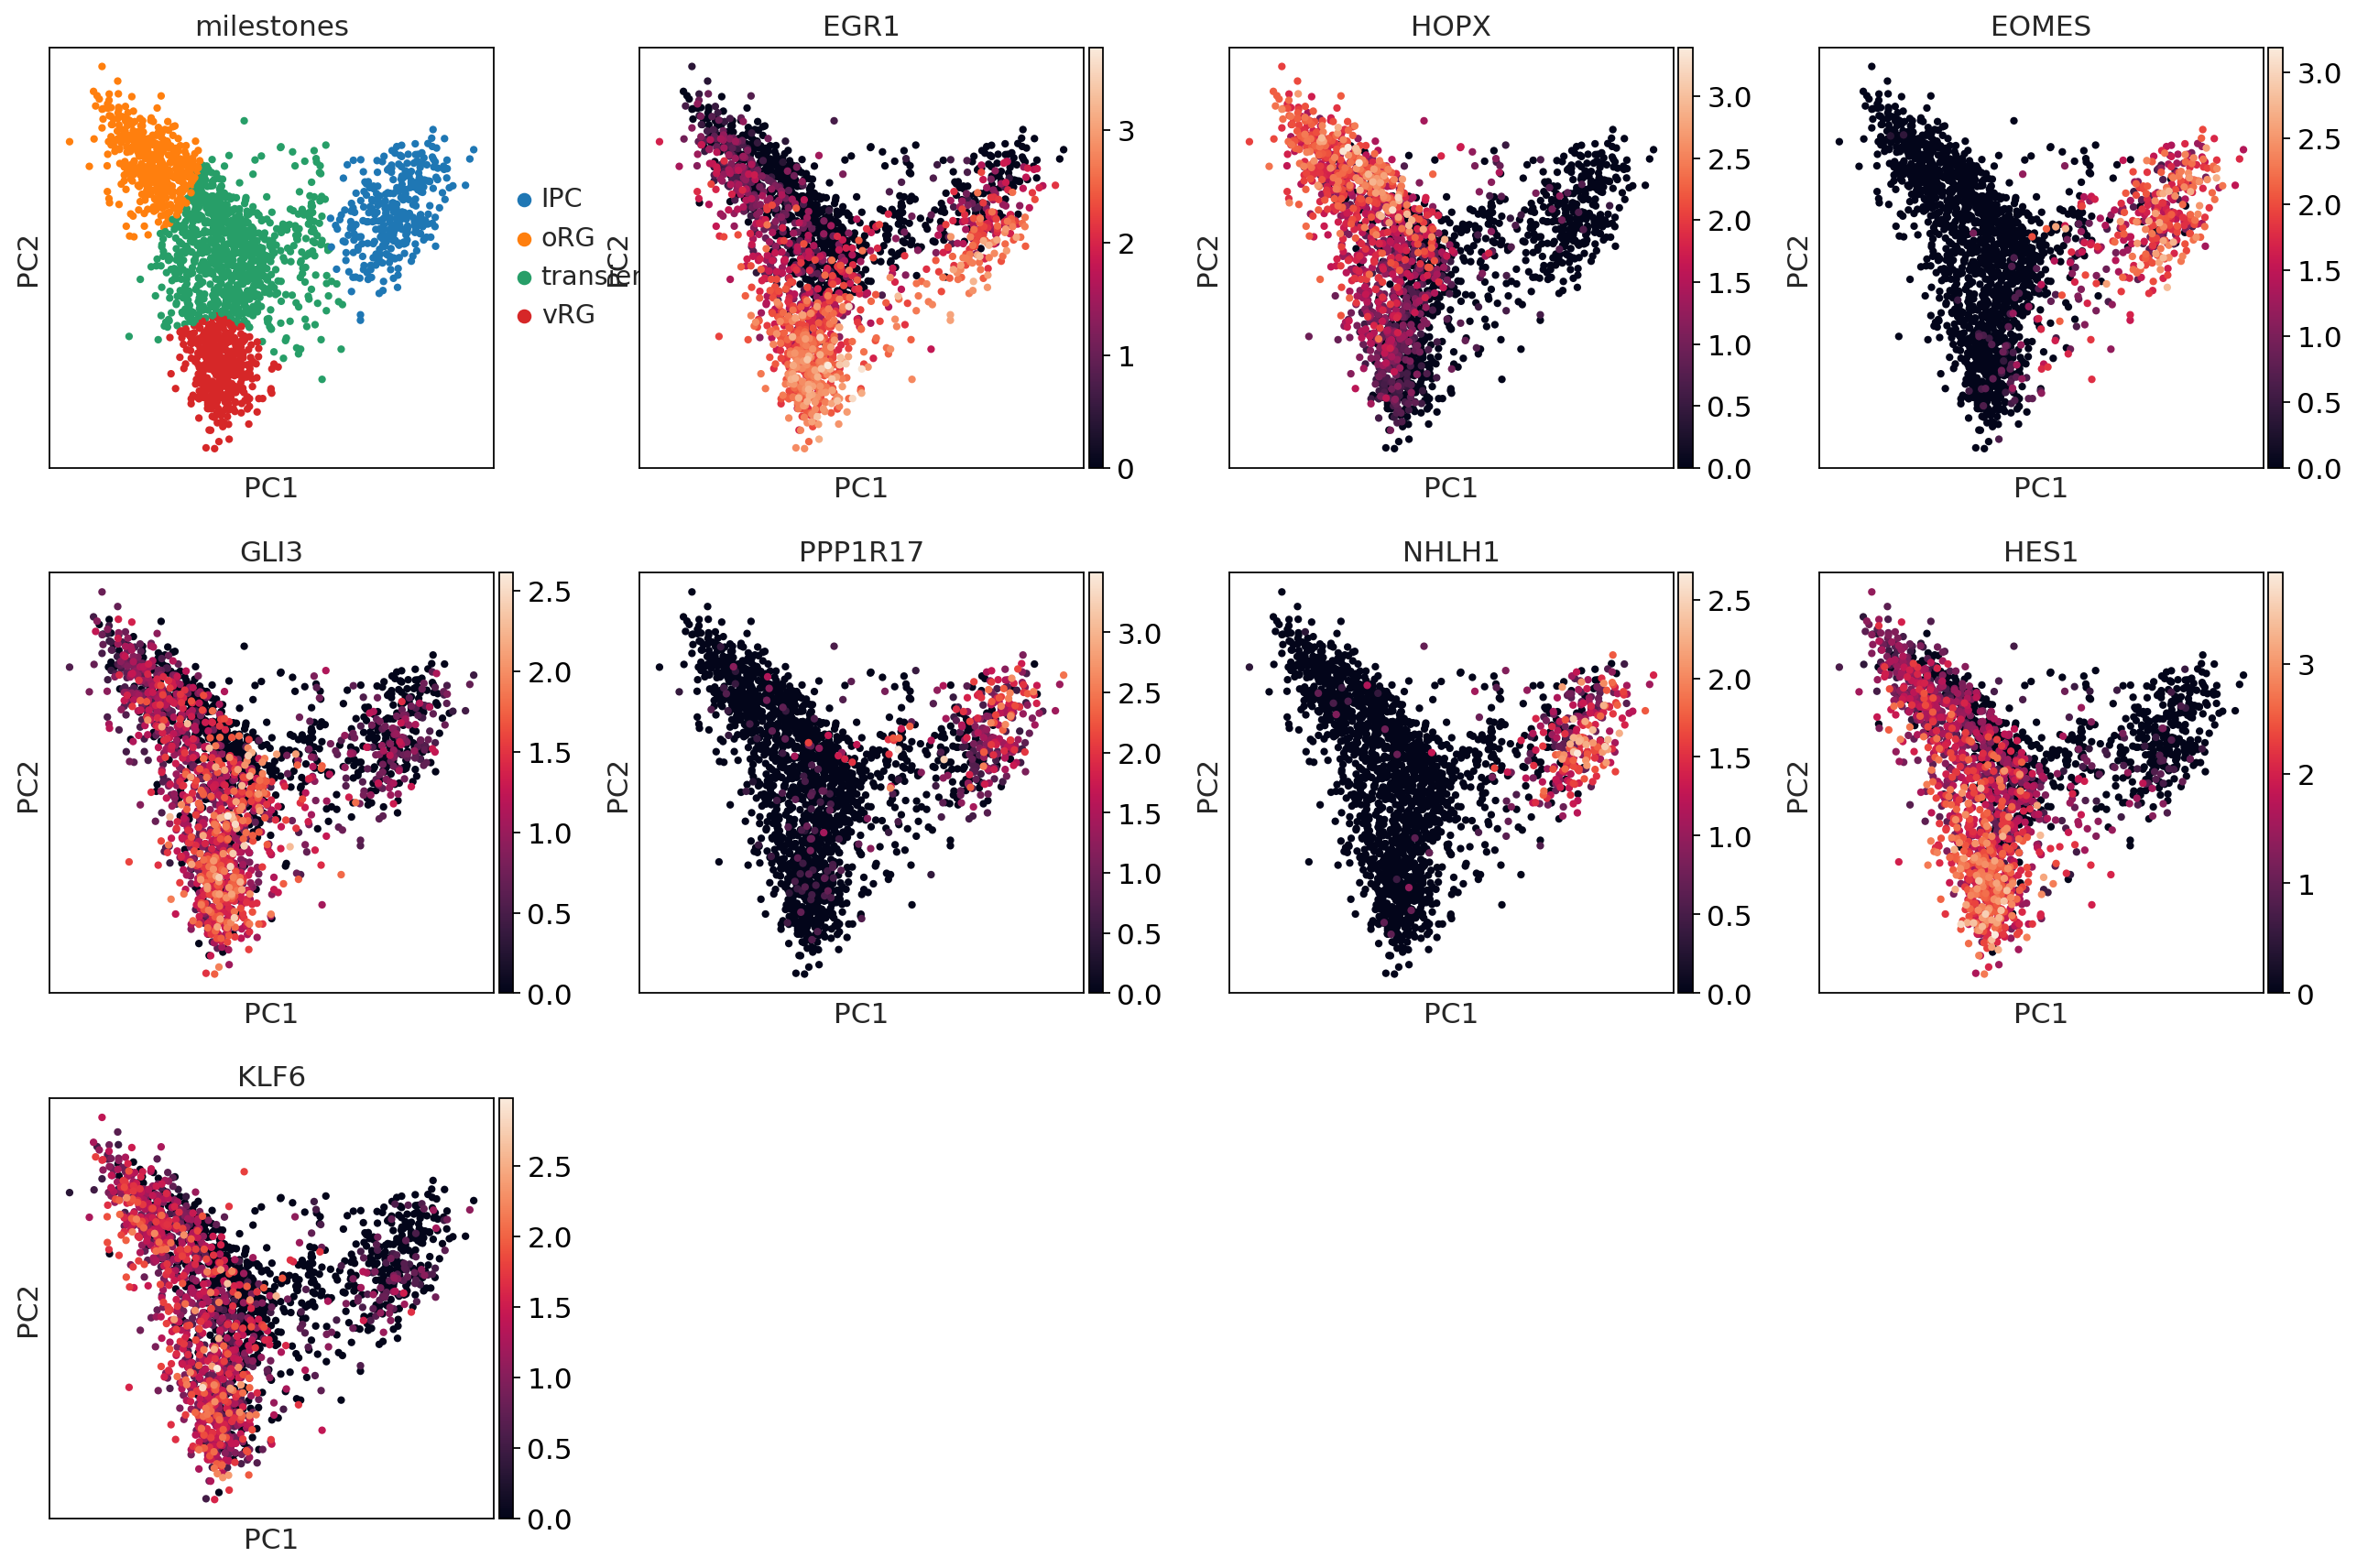

In [15]:
sc.pl.pca(adata, color=['milestones', 'EGR1', 'HOPX', 'EOMES', 'GLI3', 'PPP1R17', 'NHLH1', 'HES1', 'KLF6'], use_raw=False)

**pseudotime** (from scFates)

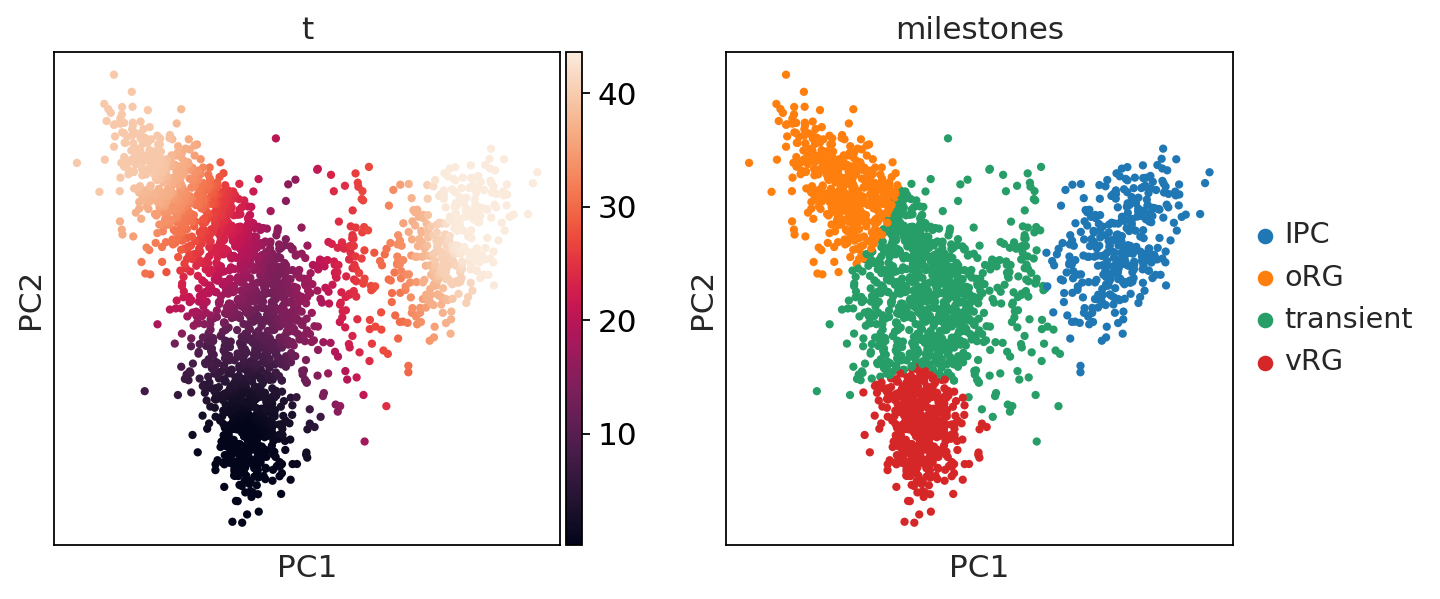

In [16]:
sc.pl.pca(adata, color=['t', 'milestones'])

**Final object**

In [17]:
adata

AnnData object with n_obs × n_vars = 2164 × 4000
    obs: 'orig.ident', 'Sample.ID', 'Age', 'Batch', 'Cluster.Name', 'percent.mt', 'percent.zeros', 'nCount_RNA', 'nFeature_RNA', 'milestones', 'segmentation', 't', 'n_counts_all'
    var: 'features', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'TF_HOCOMOCO'
    uns: 'hvg', 'log1p', 'milestones_colors'
    obsm: 'X_pca'
    layers: 'raw_count'

## **PEAKS**

In [18]:
import os, sys, shutil, importlib, glob
from tqdm.notebook import tqdm

In [19]:
from celloracle import motif_analysis as ma
from celloracle.utility import save_as_pickled_object

In [20]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = (15,7)
plt.rcParams["savefig.dpi"] = 600

In [21]:
df.head(2)

peak_id gene_short_name  AHR  AIRE  ALX1   AR  ARID5B  \
0  chr10_100006240_100006741           ABCC2  0.0   0.0   0.0  0.0     0.0   
1  chr10_100006240_100006741           DNMBP  0.0   0.0   0.0  0.0     0.0   

   ARNT  ARNTL  ASCL1  ...  ZNF680  ZNF708  ZNF76  ZNF768  ZNF770  ZNF8  \
0   0.0    0.0    0.0  ...     0.0     0.0    0.0     0.0     0.0   0.0   
1   0.0    0.0    0.0  ...     0.0     0.0    0.0     0.0     0.0   0.0   

   ZNF816  ZNF85  ZSCAN22  ZSCAN31  
0     0.0    0.0      0.0      0.0  
1     0.0    0.0      0.0      0.0  

[2 rows x 401 columns]

## 

## CellOracle

In [22]:
# Instantiate Oracle object
oracle = co.Oracle()

In [23]:
oracle

Oracle object

Meta data
    celloracle version used for instantiation: 0.10.14
    n_cells: NA
    n_genes: NA
    cluster_name: None
    dimensional_reduction_name: None
    k_for_knn_imputation: NA
Status
    Gene expression matrix: Not imported
    BaseGRN: Not imported
    PCA calculation: Not finished
    Knn imputation: Not finished
    GRN calculation for simulation: Not finished

In [24]:
# Show data name in anndata
print("metadata columns :", list(adata.obs.columns))
print("dimensional reduction: ", list(adata.obsm.keys()))

metadata columns : ['orig.ident', 'Sample.ID', 'Age', 'Batch', 'Cluster.Name', 'percent.mt', 'percent.zeros', 'nCount_RNA', 'nFeature_RNA', 'milestones', 'segmentation', 't', 'n_counts_all']
dimensional reduction:  ['X_pca']


In [25]:
#adata = adata.copy()

# In this notebook, we use the unscaled mRNA count for the input of Oracle object.
adata.X = adata.layers["raw_count"].copy()

# Instantiate Oracle object.
oracle.import_anndata_as_raw_count(adata=adata,
                                   cluster_column_name="milestones",
                                   embedding_name="X_pca") #It performs log-transform

**HOMOCOCO CELLORACLE OBJECT:**

In [26]:
# You can load TF info dataframe with the following code.
oracle.import_TF_data(TF_info_matrix=df)

In [27]:
oracle

Oracle object

Meta data
    celloracle version used for instantiation: 0.10.14
    n_cells: 2164
    n_genes: 4000
    cluster_name: milestones
    dimensional_reduction_name: X_pca
    n_target_genes_in_TFdict: 18193 genes
    n_regulatory_in_TFdict: 399 genes
    n_regulatory_in_both_TFdict_and_scRNA-seq: 83 genes
    n_target_genes_both_TFdict_and_scRNA-seq: 3557 genes
    k_for_knn_imputation: NA
Status
    Gene expression matrix: Ready
    BaseGRN: Ready
    PCA calculation: Not finished
    Knn imputation: Not finished
    GRN calculation for simulation: Not finished

19


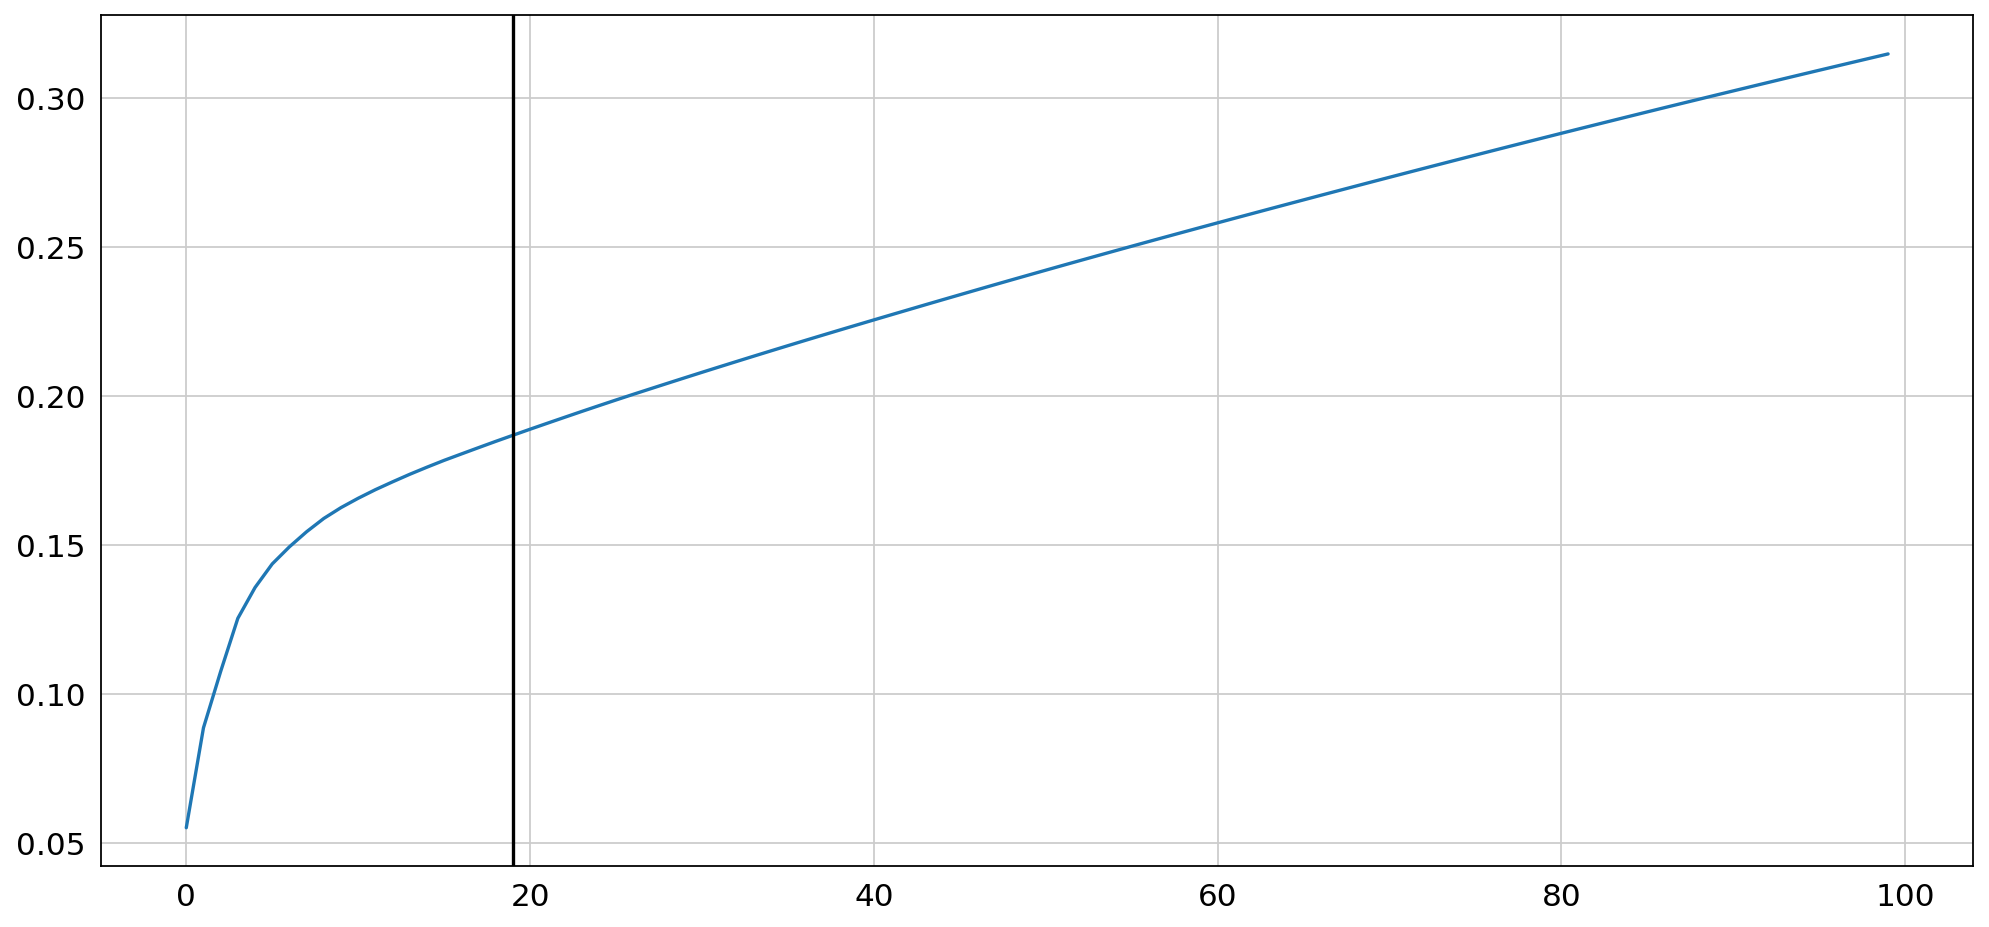

In [28]:
# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
print(n_comps)
n_comps = min(n_comps, 50)

In [29]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

cell number is :2164


In [30]:
k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

Auto-selected k is :54


In [31]:
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                      b_maxl=k*4, n_jobs=14)

In [32]:
%%time
# Calculate GRN for each population clustering unit.

links = oracle.get_links(cluster_name_for_GRN_unit='milestones', 
                         alpha=25, 
                         bagging_number=20, 
                         verbose_level=10, 
                         test_mode=False, 
                         model_method="bagging_ridge", 
                         ignore_warning=False, n_jobs=-1)

  0%|          | 0/4 [00:00<?, ?it/s]

Inferring GRN for IPC...


  0%|          | 0/3557 [00:00<?, ?it/s]

Inferring GRN for oRG...


  0%|          | 0/3557 [00:00<?, ?it/s]

Inferring GRN for transient...


  0%|          | 0/3557 [00:00<?, ?it/s]

Inferring GRN for vRG...


  0%|          | 0/3557 [00:00<?, ?it/s]

CPU times: user 12min 13s, sys: 58.6 s, total: 13min 11s
Wall time: 13min 53s


In [33]:
%%time
# Calculate GRN for each population clustering unit.
# This step may take some time.(~30 minutes)

links_bayesian_ridge = oracle.get_links(cluster_name_for_GRN_unit='milestones', 
                         alpha=25, 
                         bagging_number=20, 
                         verbose_level=10, 
                         test_mode=False, 
                         model_method="bayesian_ridge", 
                         ignore_warning=False, n_jobs=-1)

  0%|          | 0/4 [00:00<?, ?it/s]

Inferring GRN for IPC...


  0%|          | 0/3557 [00:00<?, ?it/s]

Inferring GRN for oRG...


  0%|          | 0/3557 [00:00<?, ?it/s]

Inferring GRN for transient...


  0%|          | 0/3557 [00:00<?, ?it/s]

/root/miniconda/envs/celloracle_env/lib/python3.8/site-packages/celloracle/network/net_core.py:651: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/root/miniconda/envs/celloracle_env/lib/python3.8/site-packages/celloracle/network/net_core.py:651: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/root/miniconda/envs/celloracle_env/lib/python3.8/site-packages/celloracle/network/net_core.py:651: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/root/miniconda/envs/celloracle_env/lib/python3.8/site-packages/celloracle/network/net_core.py:651: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/root/miniconda/envs/celloracle_env/lib/python3.8/site-packages/celloracle/network/net_core.py:651: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/root/miniconda/envs/celloracle_env/lib/python3.8/site-packages/celloracle/network/net_core.py:651: RuntimeWarning: divide by

Inferring GRN for vRG...


  0%|          | 0/3557 [00:00<?, ?it/s]

/root/miniconda/envs/celloracle_env/lib/python3.8/site-packages/celloracle/network/net_core.py:651: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


CPU times: user 12min 12s, sys: 44.8 s, total: 12min 56s
Wall time: 1min 28s


**P VALUE - bagging_ridge**

In [34]:
links.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)

**P VALUE - bayesian_ridge**

In [35]:
links_bayesian_ridge.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)

In [36]:
for i in links.filtered_links.keys():

    links.filtered_links[i].to_csv(save_filtered_links+"GRN_for_"+i+"_baggingridge_pcw16.csv", index=False)

**bayesian_ridge**

In [37]:
for i in links.filtered_links.keys():

    links_bayesian_ridge.filtered_links[i].to_csv(save_filtered_links+"alt_GRN_for_"+i+"_bayesianridge_pcw16.csv", index=False)

In [38]:
plt.rcParams["figure.figsize"] = [6, 4.5]

IPC


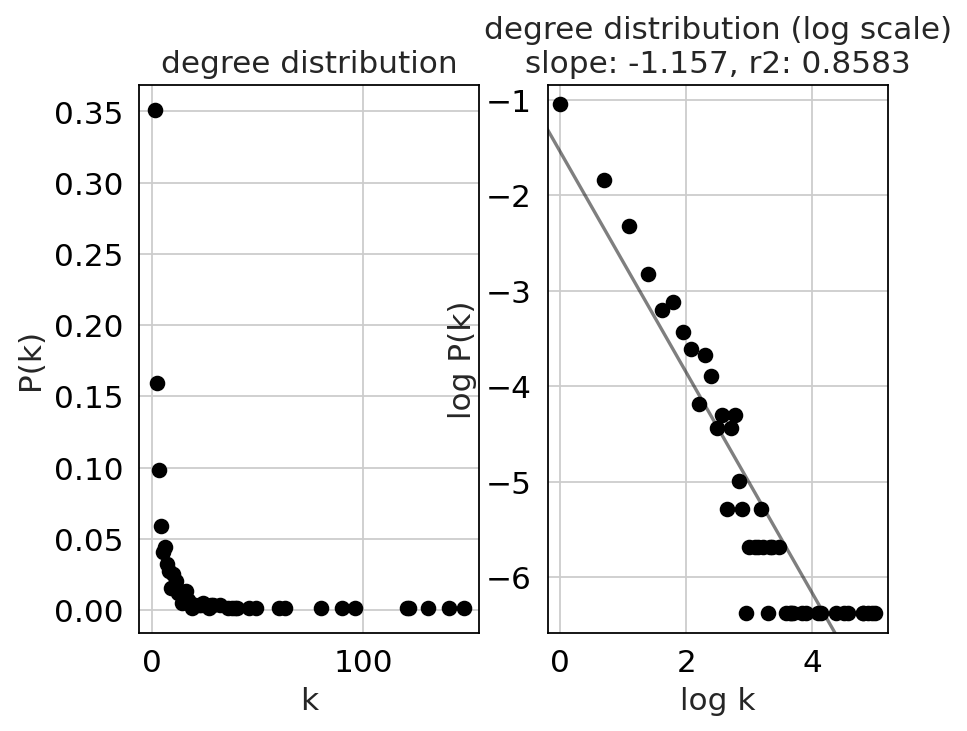

oRG


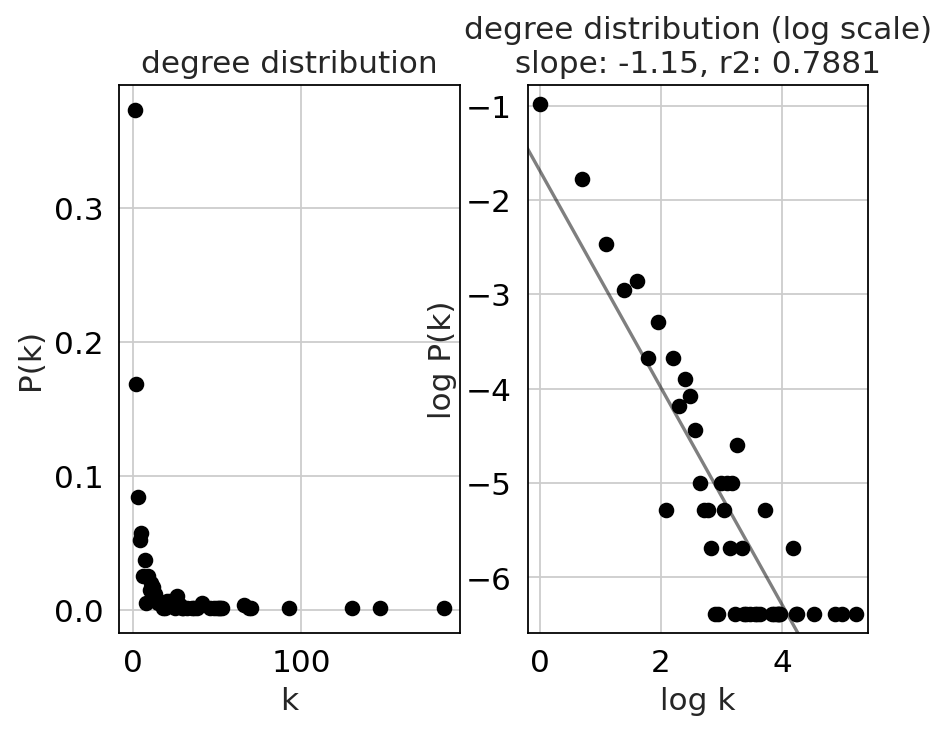

transient


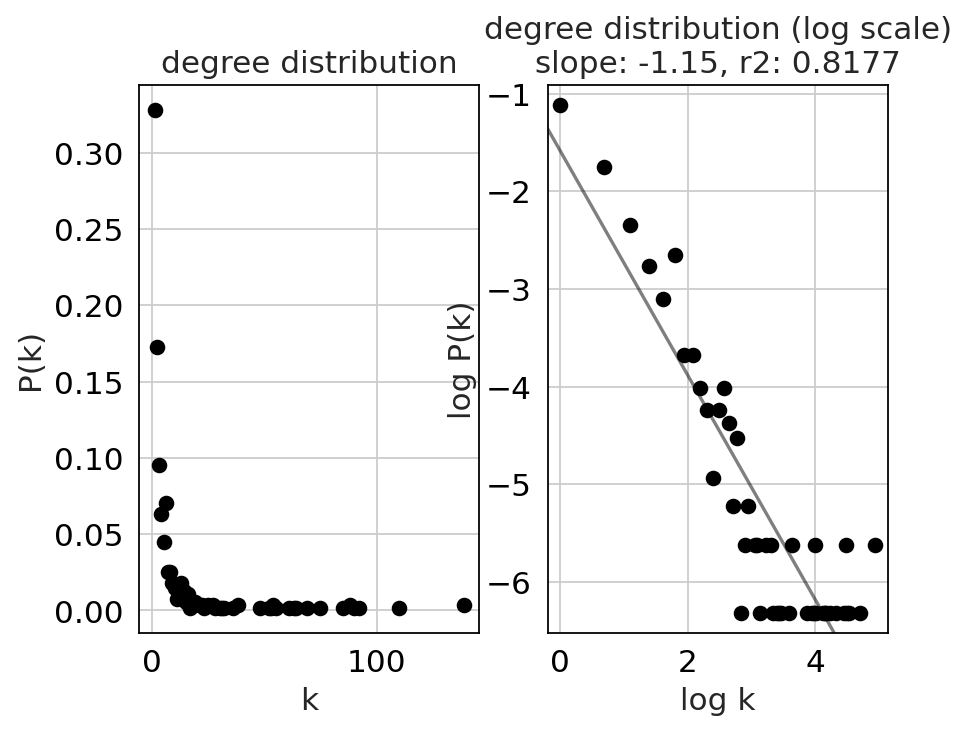

vRG


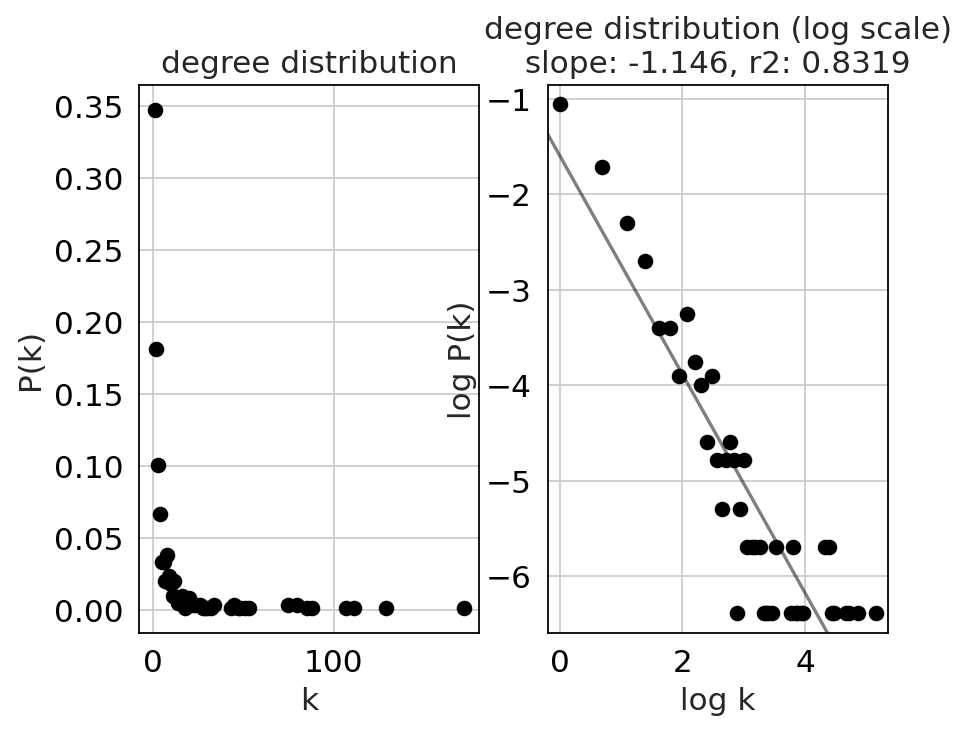

In [39]:
links.plot_degree_distributions(plot_model=True)#save=f"{save_folder}/degree_distribution/",)

**Higher r2 scores for bagging ridge algorithm**

IPC


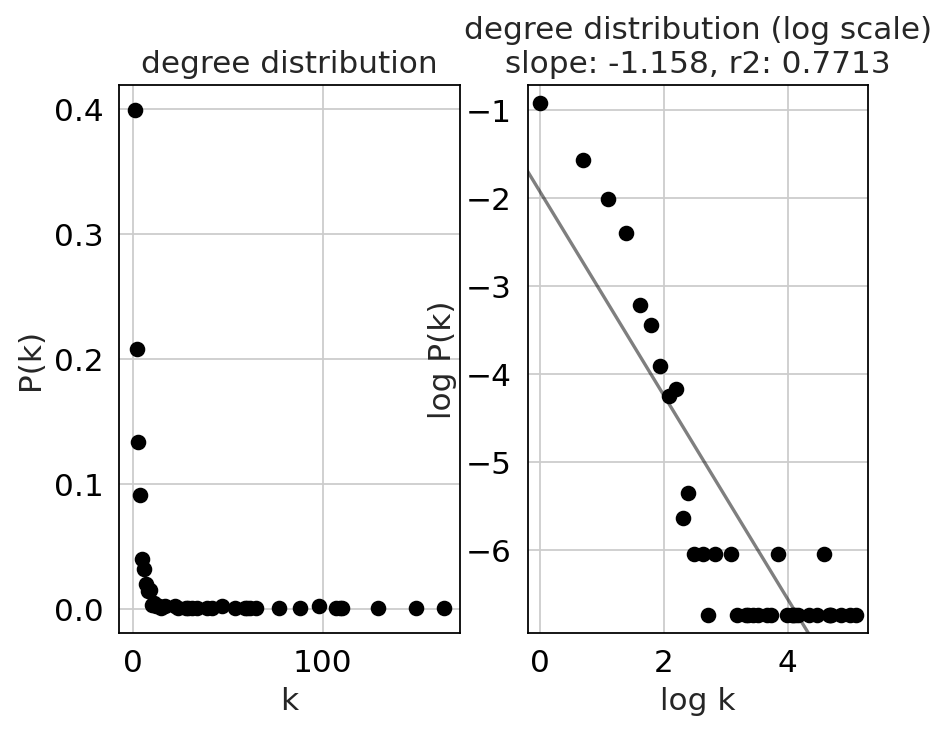

oRG


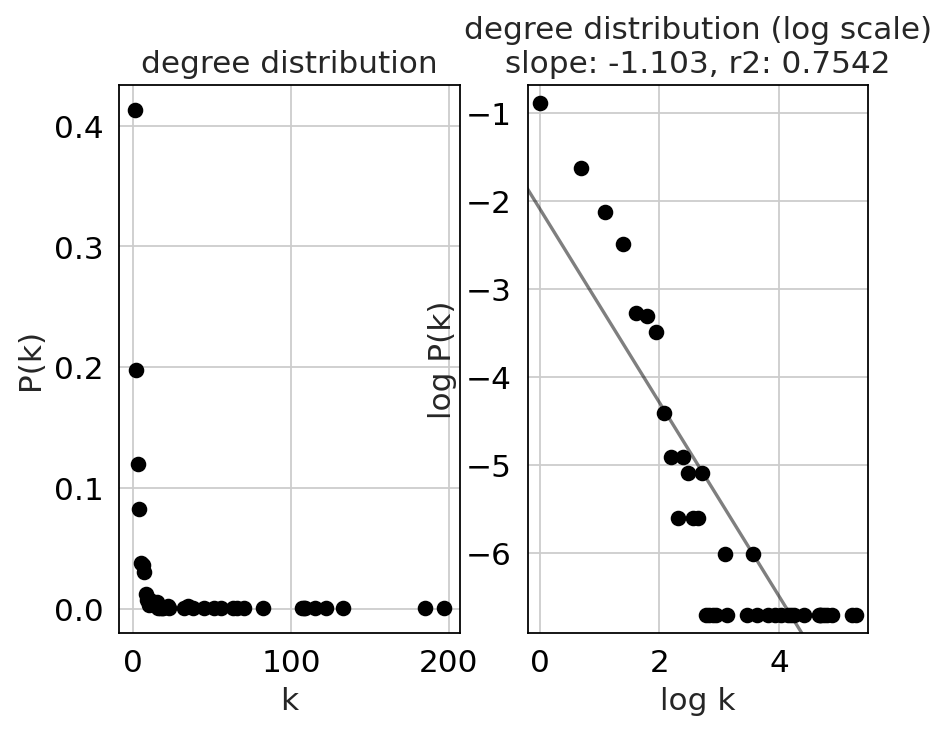

transient


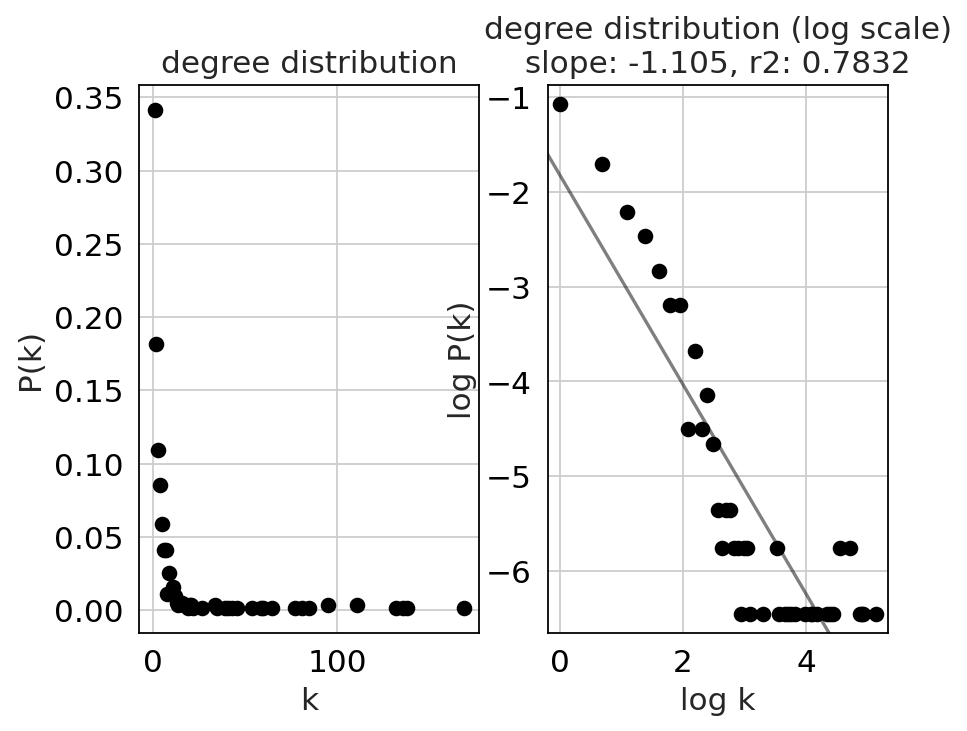

vRG


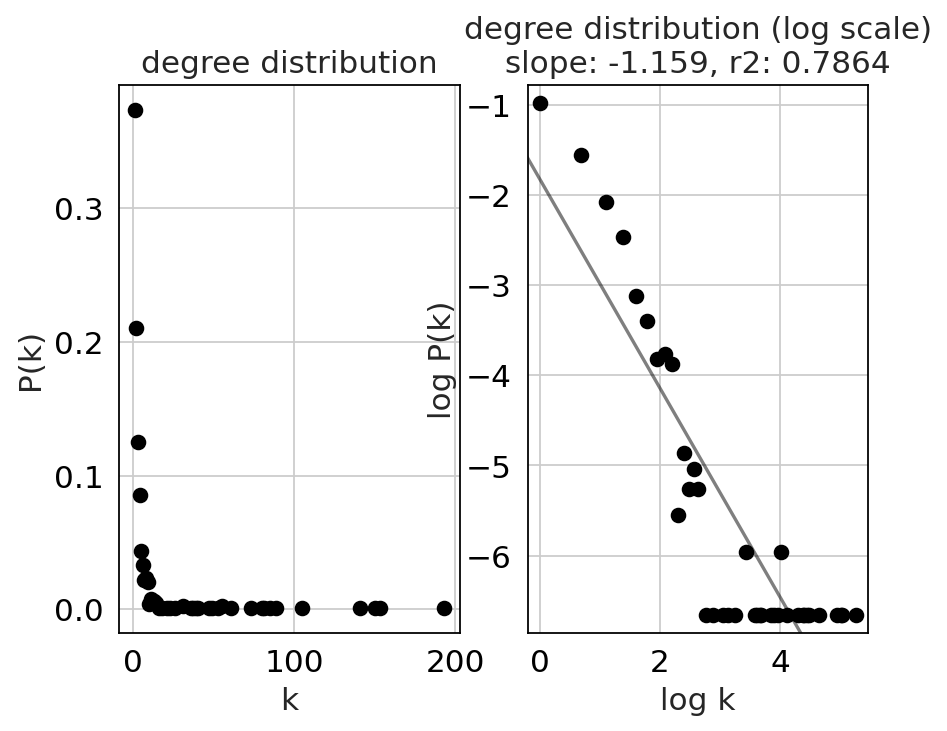

In [40]:
links_bayesian_ridge.plot_degree_distributions(plot_model=True)#save=f"{save_folder}/degree_distribution/",)

In [41]:
# Calculate network scores.
links.get_network_score()

In [42]:
links.merged_score.head()

degree_all  degree_centrality_all  degree_in  degree_centrality_in  \
EGR1           145               0.246180         31              0.052632   
FOS             47               0.079796         29              0.049236   
INSM1           52               0.088285          5              0.008489   
DDAH2            5               0.008489          5              0.008489   
TFAP2C         132               0.224109          4              0.006791   

        degree_out  degree_centrality_out  betweenness_centrality  \
EGR1           114               0.193548                  8358.0   
FOS             18               0.030560                  5237.0   
INSM1           47               0.079796                  1728.0   
DDAH2            0               0.000000                     0.0   
TFAP2C         128               0.217317                  7579.0   

        eigenvector_centrality cluster  
EGR1                  1.000000     IPC  
FOS                   0.514607     IPC  
INSM1                 0.272297     IPC  
DDAH2                 0.129944     IPC  
TFAP2C                0.583837     IPC

**links_bayesian_ridge**

In [43]:
links_bayesian_ridge.get_network_score()

In [44]:
links_bayesian_ridge.merged_score.head()

degree_all  degree_centrality_all  degree_in  degree_centrality_in  \
EGR1          168               0.198582         11              0.013002   
FOS            36               0.042553          9              0.010638   
JUN            61               0.072104          8              0.009456   
MCM4            3               0.003546          3              0.003546   
INSM1         103               0.121749          8              0.009456   

       degree_out  degree_centrality_out  betweenness_centrality  \
EGR1          157               0.185579                  4877.0   
FOS            27               0.031915                  4368.0   
JUN            53               0.062648                  2759.0   
MCM4            0               0.000000                     0.0   
INSM1          95               0.112293                  6050.0   

       eigenvector_centrality cluster  
EGR1                 1.000000     IPC  
FOS                  0.474966     IPC  
JUN                  0.304346     IPC  
MCM4                 0.124304     IPC  
INSM1                0.553870     IPC

In [45]:
# Save Links object.
links.to_hdf5(file_path="/home/jovyan/jm_jlab/data_indNeuro/1.GRN/milestones_pcw16_baggindridge.celloracle.links")

In [46]:
# links_bayesian_ridge
# Save Links object.
links_bayesian_ridge.to_hdf5(file_path="/home/jovyan/jm_jlab/data_indNeuro/1.GRN/alt_milestones_pcw16_bayesianridge.celloracle.links")

## Network analysis

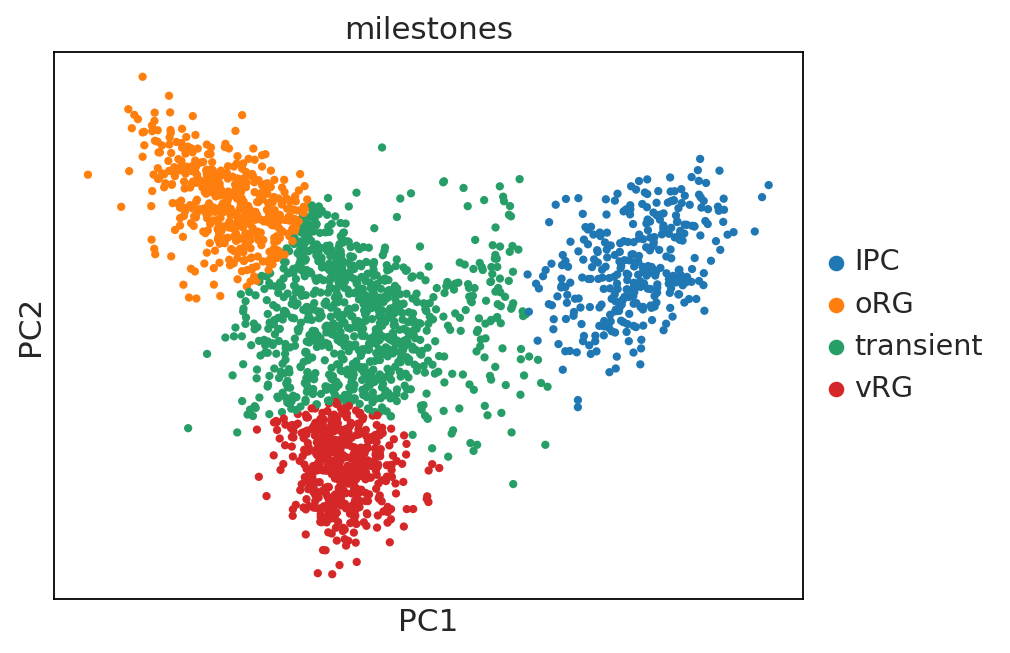

In [47]:
sc.pl.pca(adata, color='milestones')

IPC


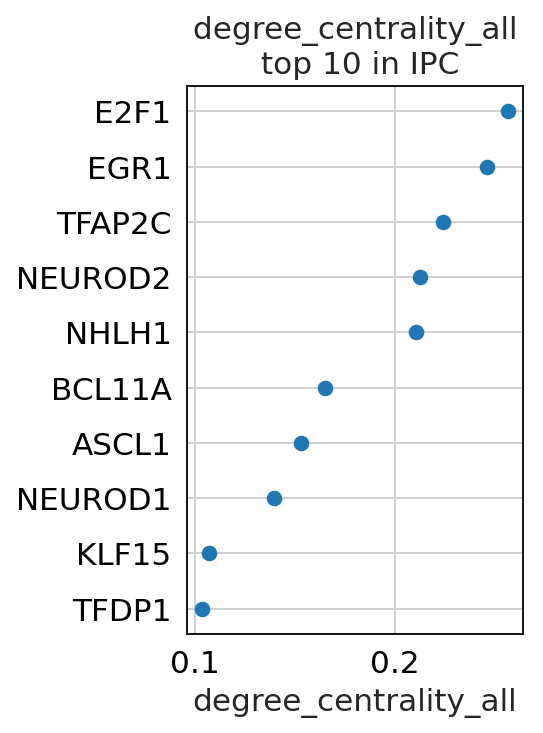

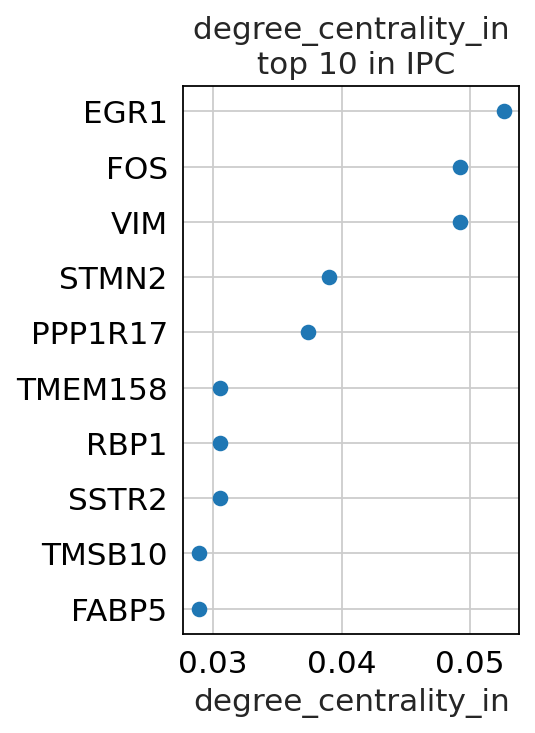

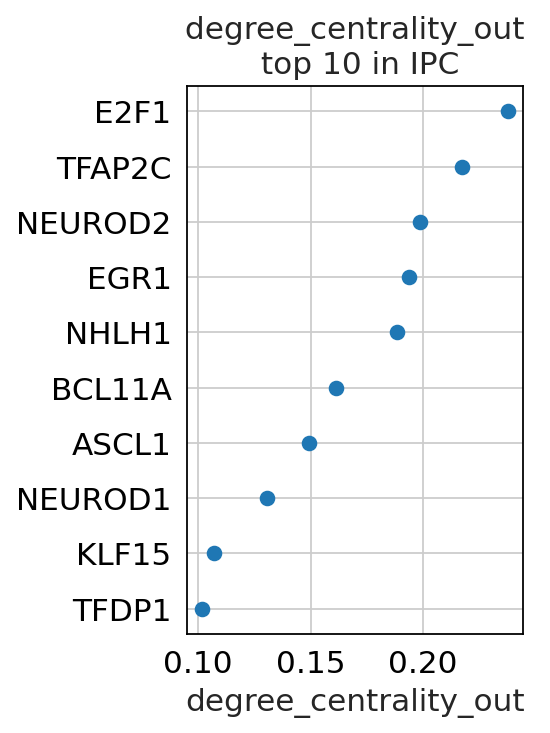

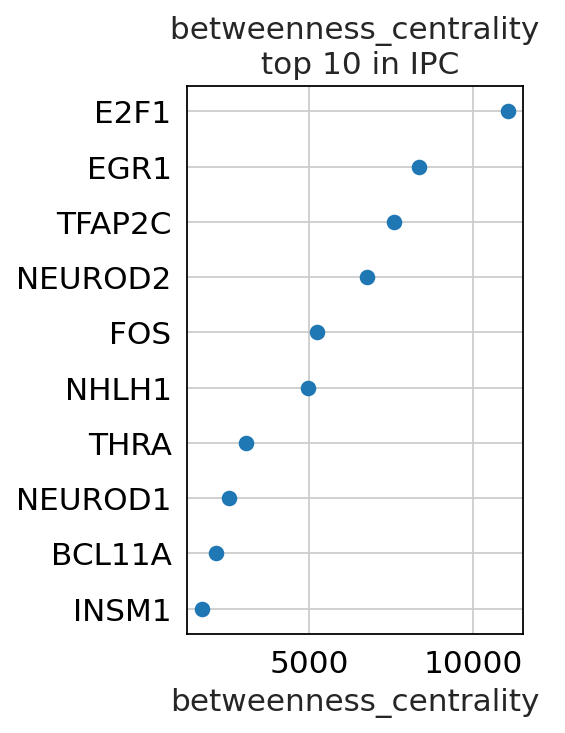

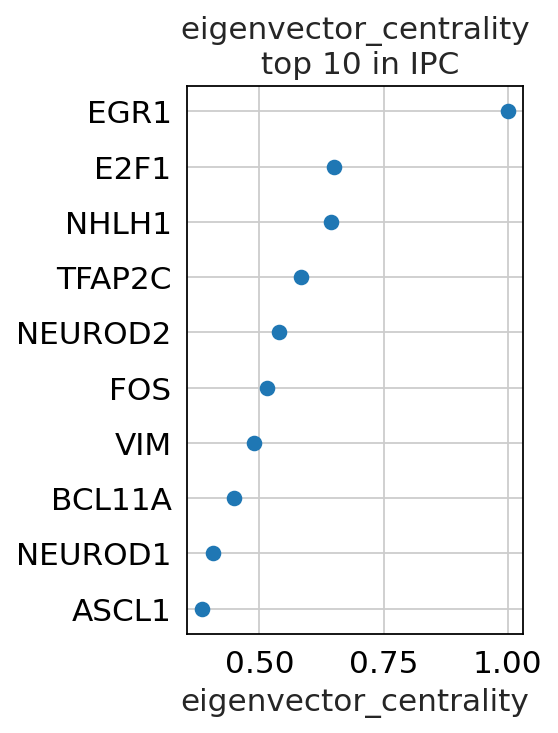

oRG


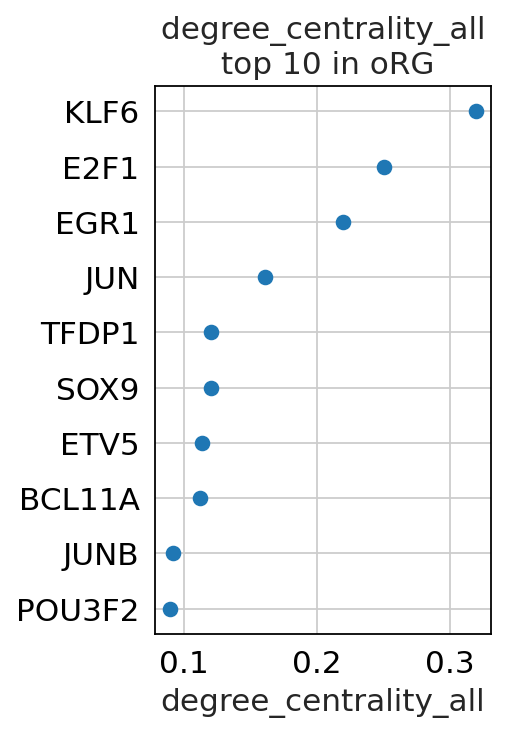

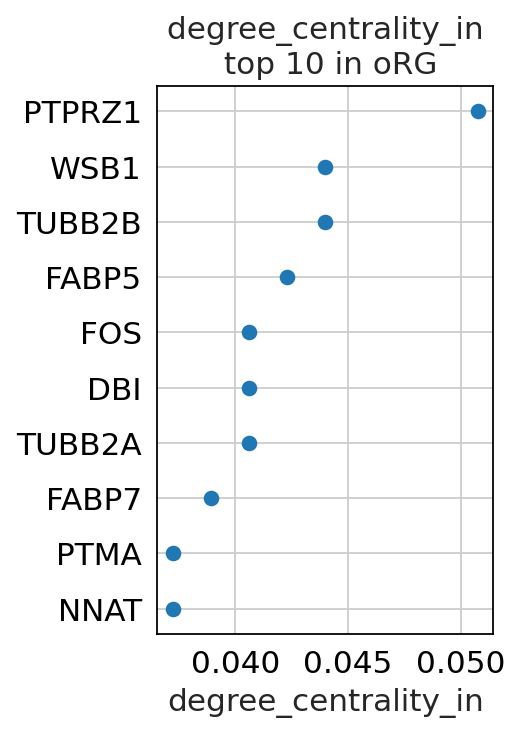

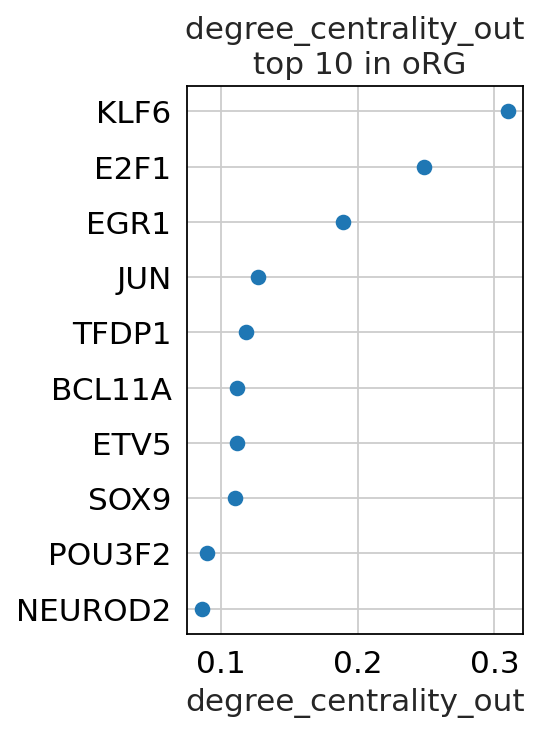

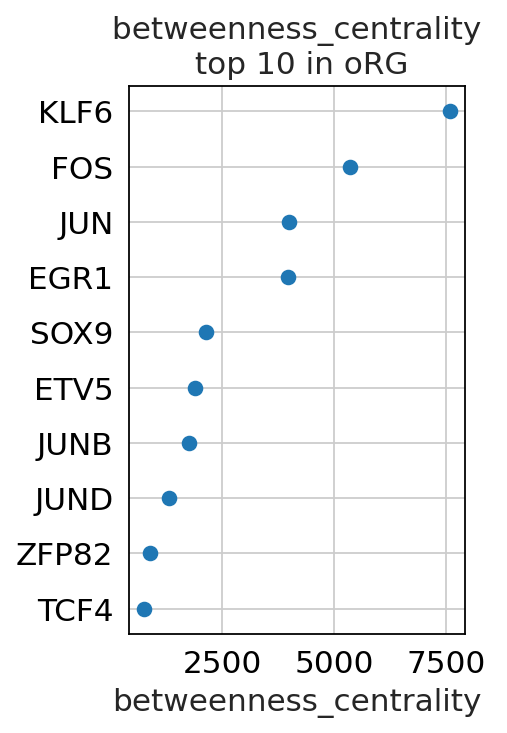

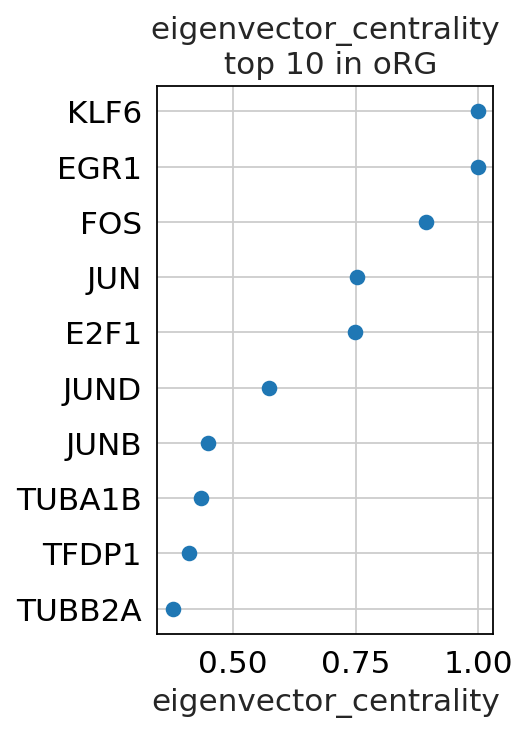

transient


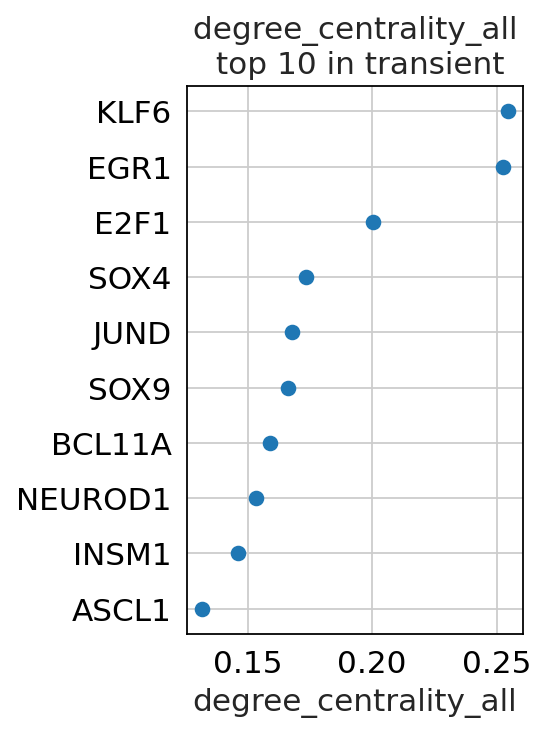

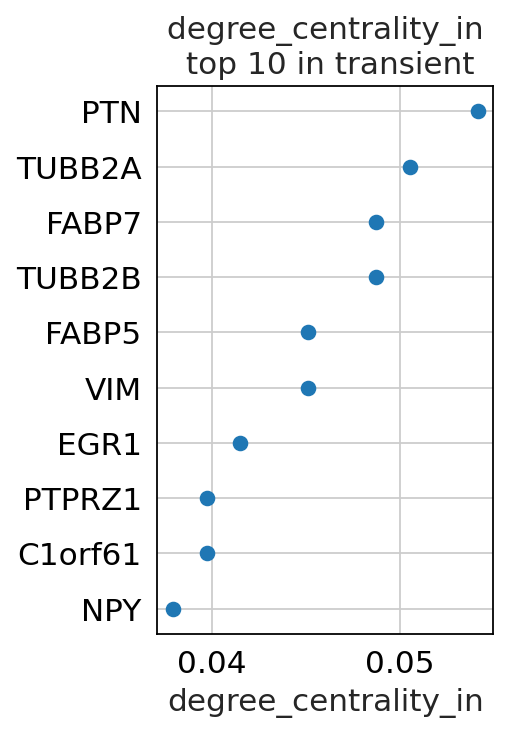

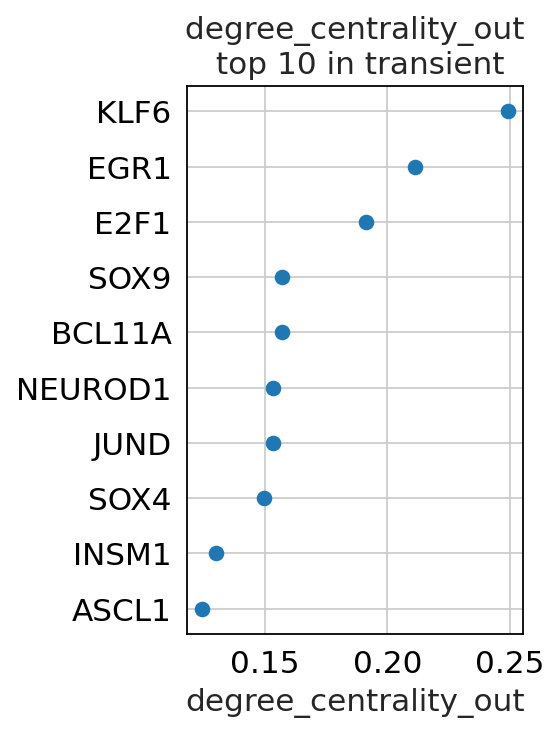

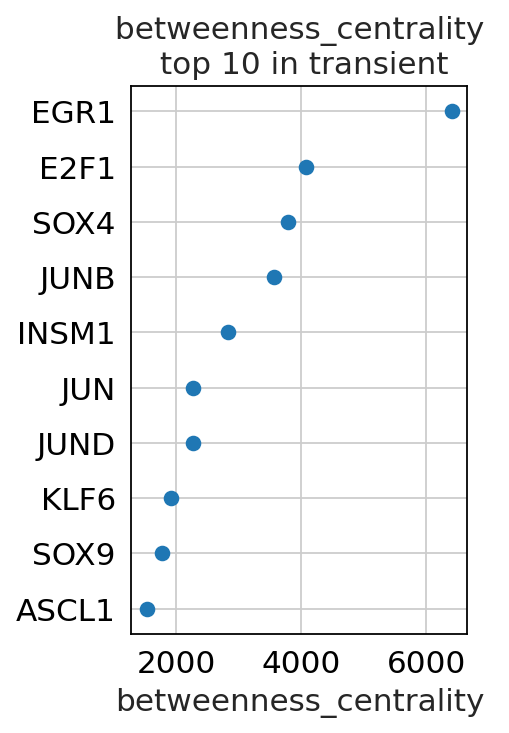

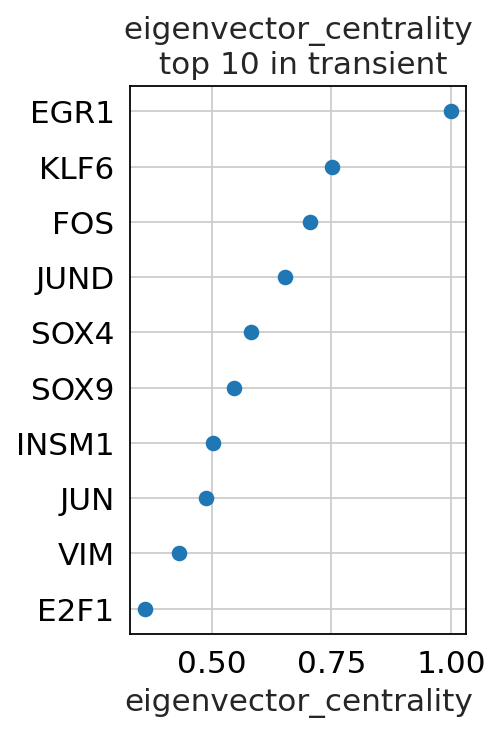

vRG


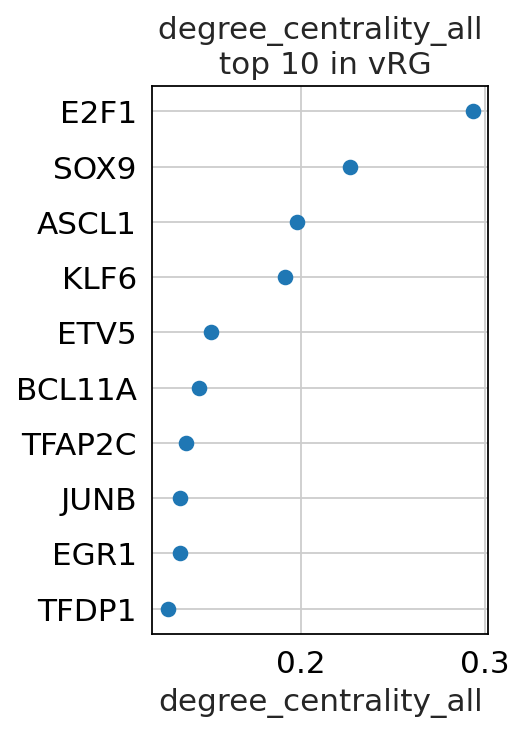

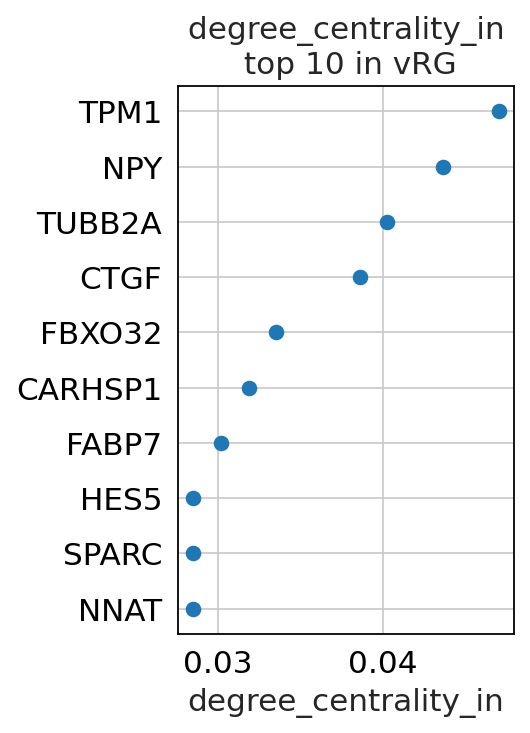

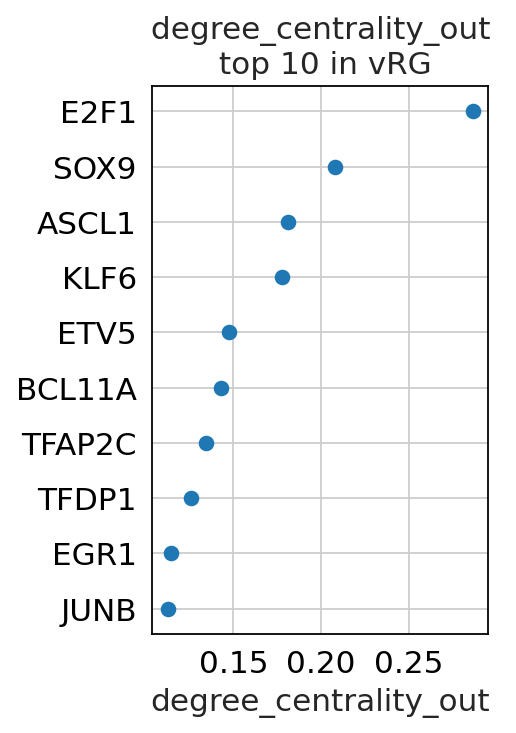

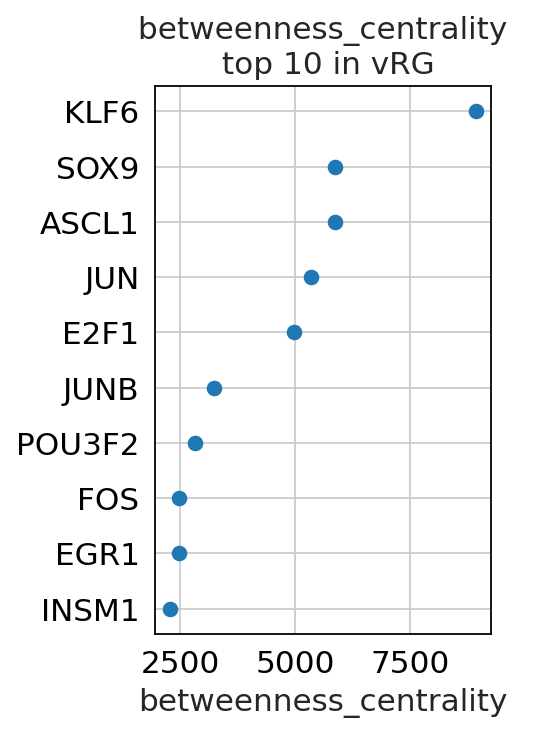

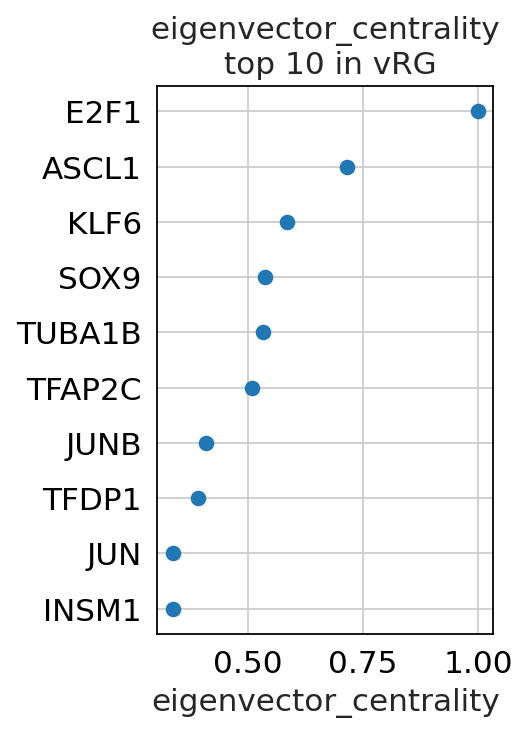

In [48]:
for i in links.filtered_links.keys():

    print(i)
    
    links.plot_scores_as_rank(cluster=i, n_gene=10)

IPC


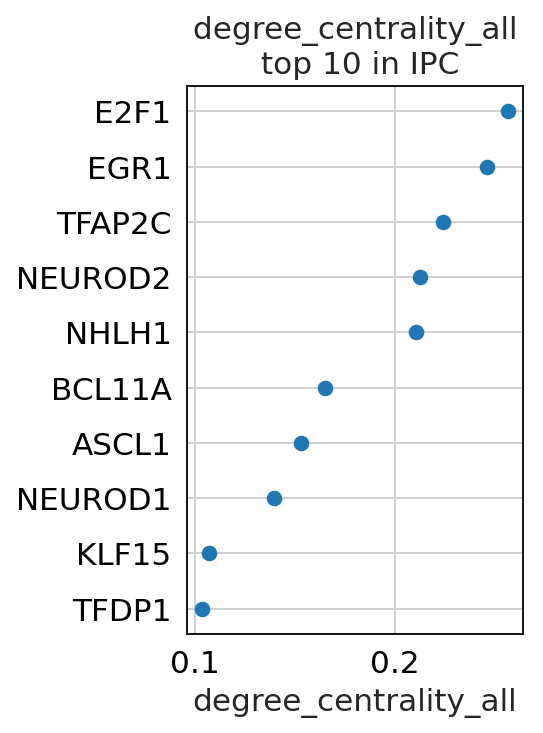

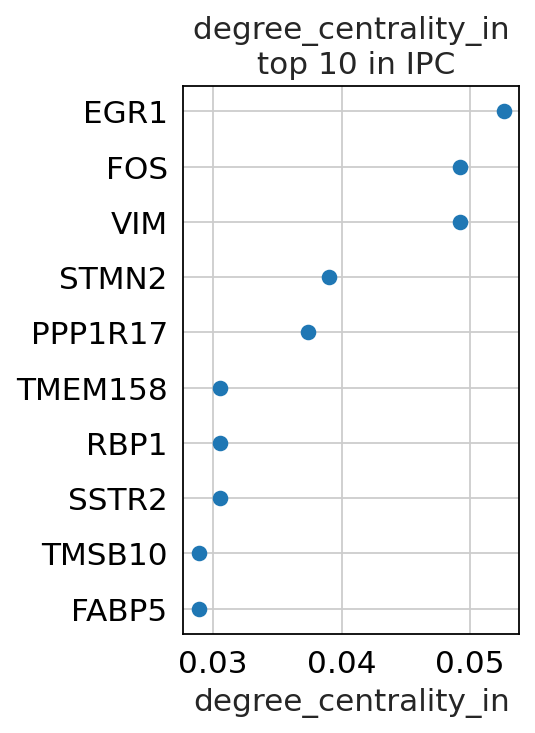

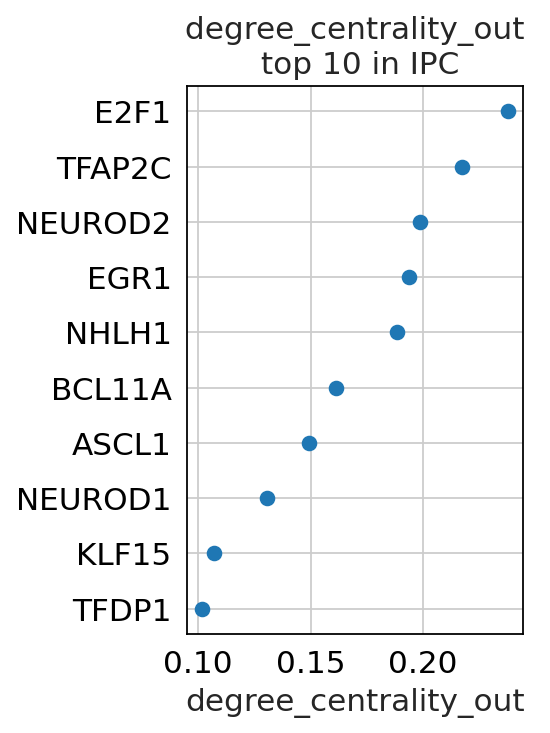

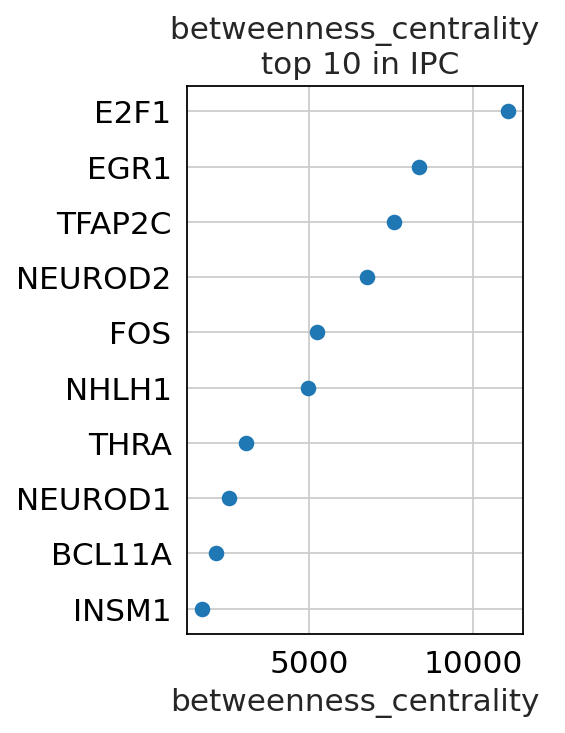

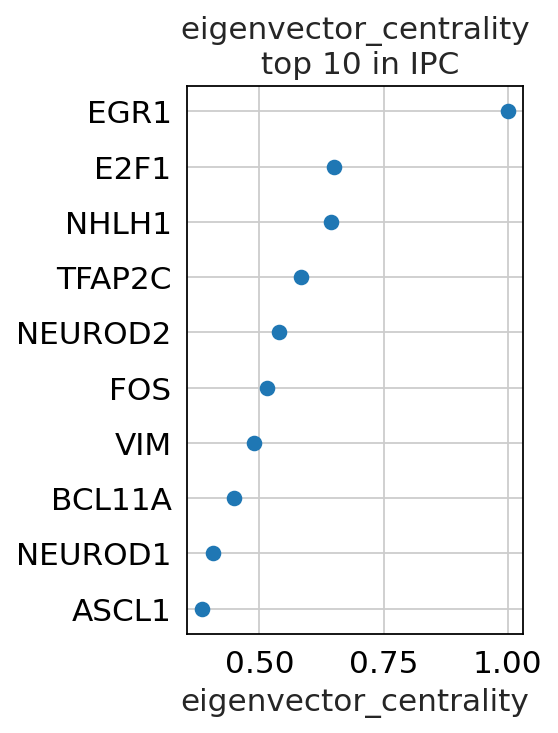

oRG


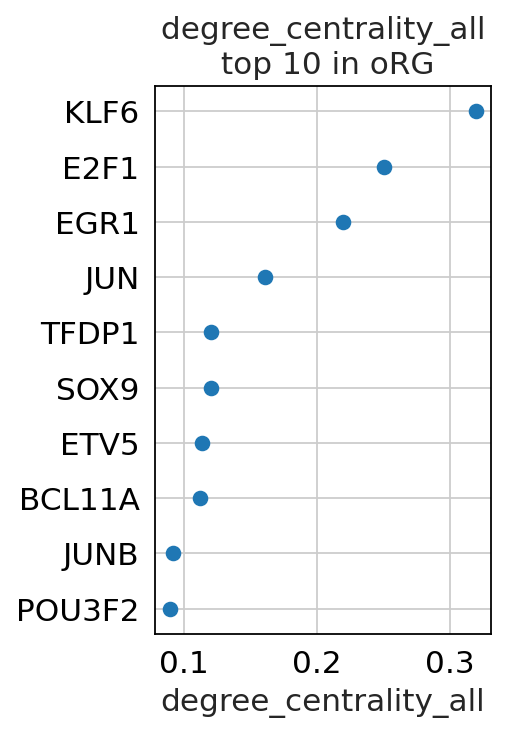

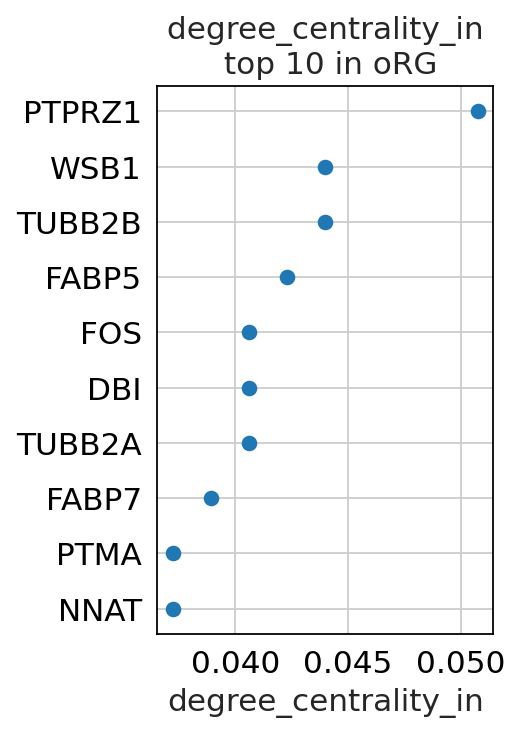

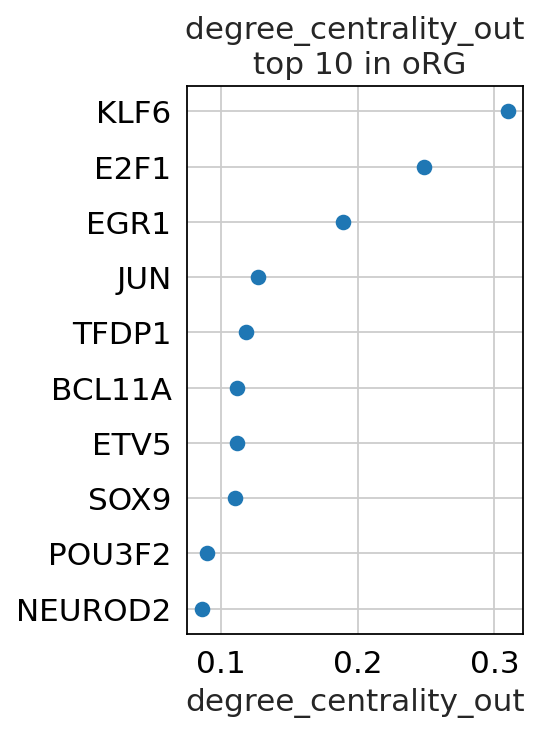

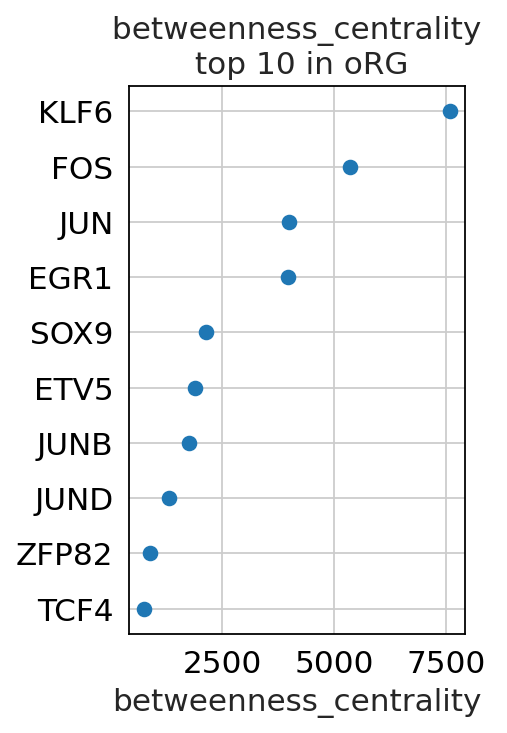

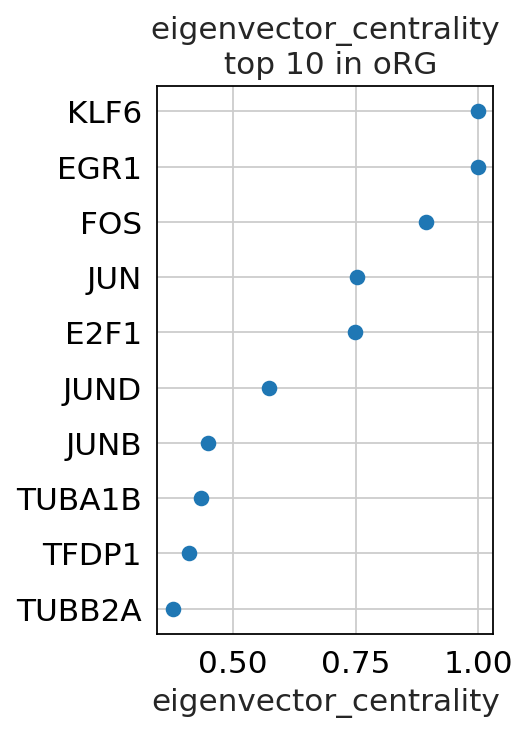

transient


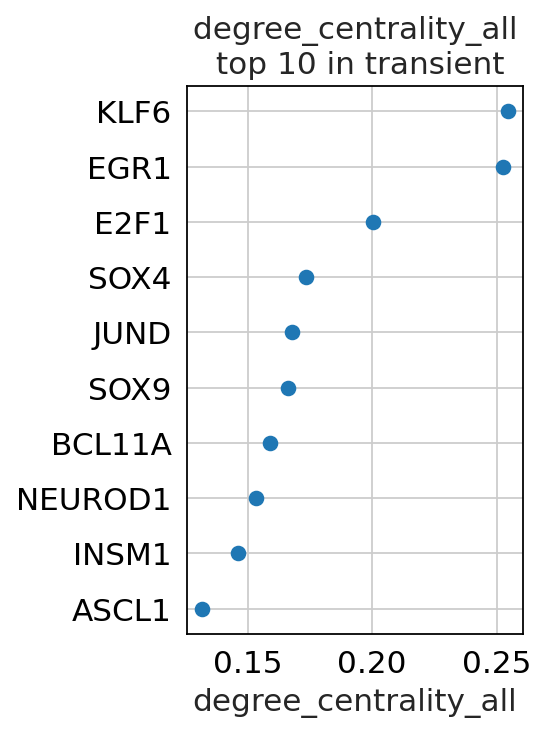

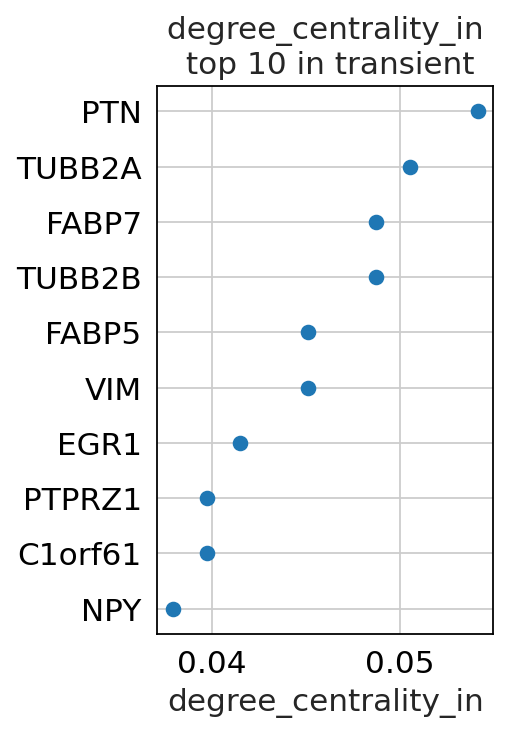

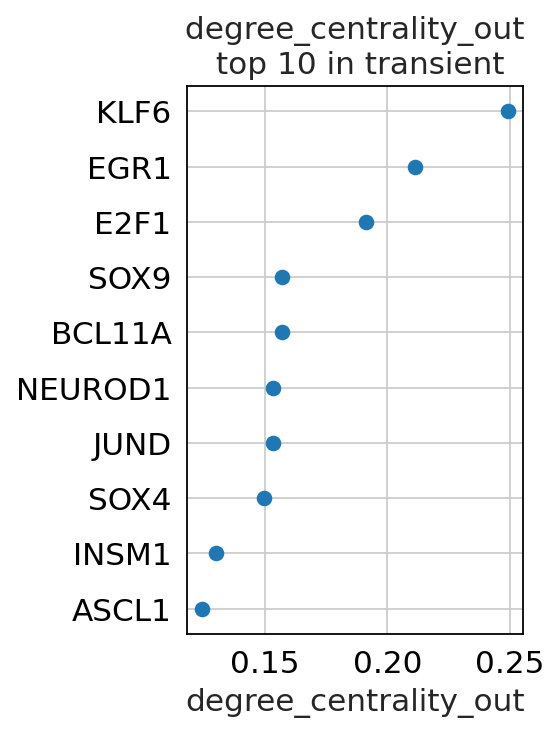

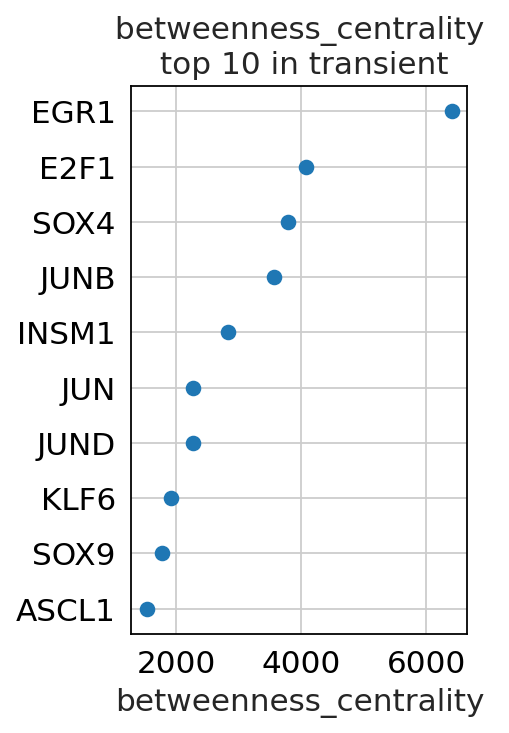

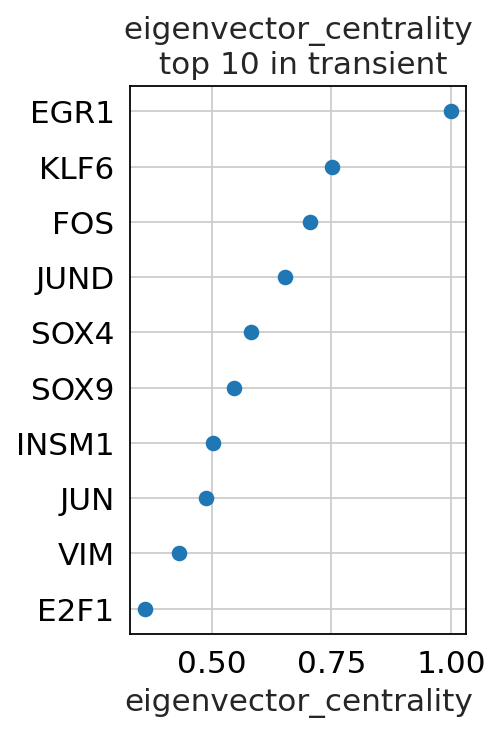

vRG


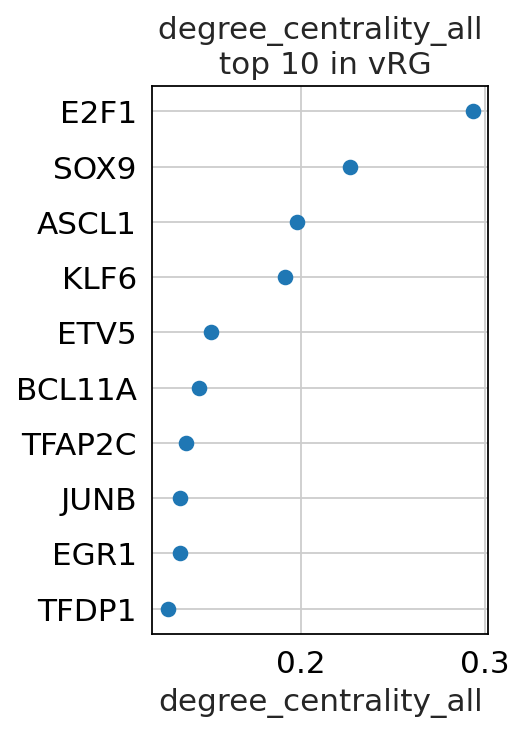

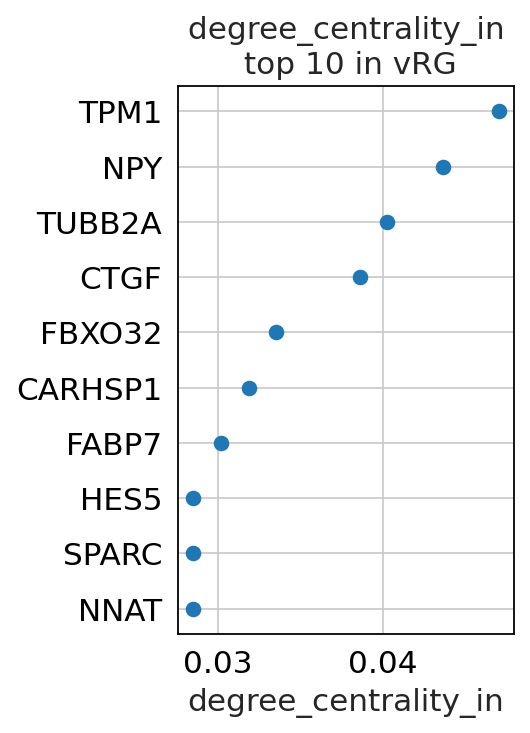

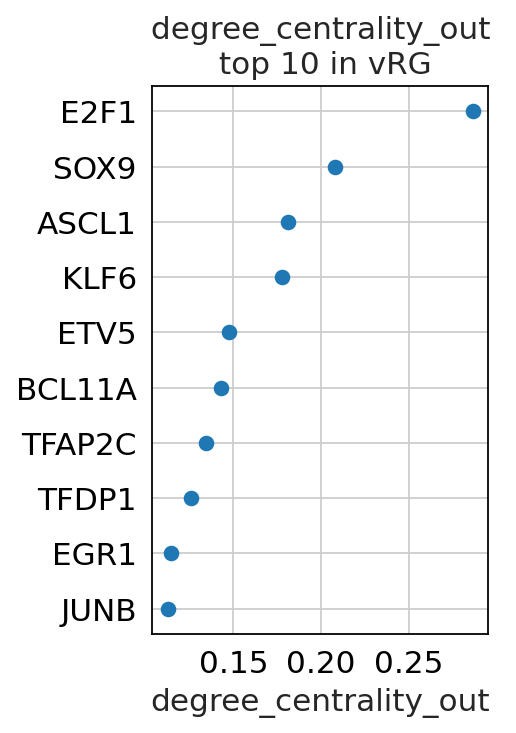

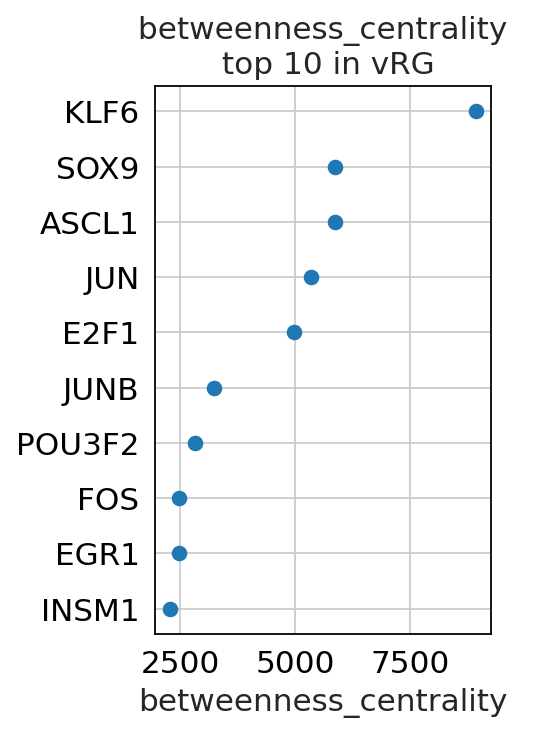

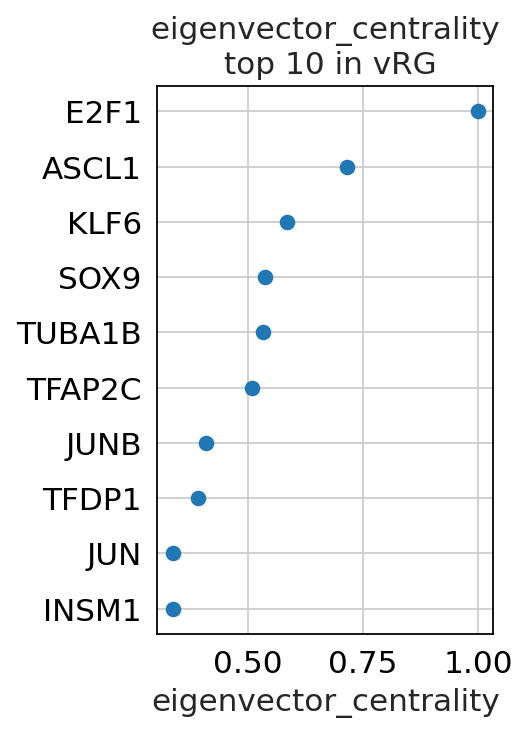

In [49]:
for i in links.filtered_links.keys():

    print(i)
    
    links.plot_scores_as_rank(cluster=i, n_gene=10, save=save_filtered_links+"GRN_for_"+i+"_pcw16")

# Save Oracle object pcw16

In [50]:
oracle.to_hdf5("/home/jovyan/jm_jlab/data_indNeuro/1.GRN/tr21_pcw16.celloracle.oracle")